<a href="https://colab.research.google.com/github/Nganle21/Amazon_Waffeleisen/blob/main/MA_SP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -m spacy download en_core_web_lg
!pip install category_encoders
!pip install sklearn_crfsuite
!pip install -U 'scikit-learn<0.24'
!pip install transformers
!pip install vaderSentiment
!pip install bert-for-tf2

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-21 08:30:13.651706: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 15 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 612 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |█████████████████████

Use first created file train and test from Jedox

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import operator
import math
import spacy
import scipy
from tqdm import tqdm
nlp = spacy.load('en_core_web_lg')
from sklearn.model_selection import train_test_split
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.util import ngrams
n_gram = 1
from nltk.tokenize.treebank import TreebankWordDetokenizer
kfold=10
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc, f1_score, recall_score, precision_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt 
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import WhitespaceTokenizer
import category_encoders as ce

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

import tensorflow as tf
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding, Dense, TimeDistributed, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Activation, SpatialDropout1D, Bidirectional, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import load_model
from tensorflow import keras


import keras as k
import keras.backend as K

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

import transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from bert.model import BertModelLayer
from bert.loader import params_from_pretrained_ckpt, load_stock_weights

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Split Train Test

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/admin.xlsx",engine="openpyxl")
#df.head()
train, test = train_test_split(df, test_size=0.3, random_state = 29)
#train.to_excel("/content/drive/MyDrive/Colab Notebooks/absa_train.xlsx")
#test.to_excel("/content/drive/MyDrive/Colab Notebooks/absa_test.xlsx")



# Data Preprocessing

In [ ]:
#train = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/train_final.xlsx",engine="openpyxl")
#test = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/test_final.xlsx",engine="openpyxl")

In [ ]:
train_sp = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/train.xlsx",engine="openpyxl")
test_sp = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/test.xlsx",engine="openpyxl")

/usr/local/lib/python3.8/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
test_sp

,id,text,aspectTerm,From,To,SP
0,142090,Perfect. Waffles succeed straight away. Gladly...,Waffles,9,16,positive
1,142096,"The waffles are not evenly browned, unfortunat...",waffles,4,11,negative
2,142096,"The waffles are not evenly browned, unfortunat...",regulation of the temperature,62,91,negative
3,142096,"The waffles are not evenly browned, unfortunat...",use,111,114,neutral
4,142096,"The waffles are not evenly browned, unfortunat...",use,137,140,neutral
...,...,...,...,...,...,...
462,145346,It is very simple to handle and the price qual...,coating,81,88,positive
463,145357,"Easy to clean, heat enough and the materials s...",clean,8,13,positive
464,145357,"Easy to clean, heat enough and the materials s...",heat,15,19,positive
465,145357,"Easy to clean, heat enough and the materials s...",materials,35,44,positive


##Data Exploration + Feature Selection SP

### Feature Selection

#### Create COC

In [ ]:
train_sp

,id,text,aspectTerm,From,To,SP
0,142087,I am very satisfied with it ... I have used th...,price,82,87,positive
1,142089,"Cheap processing, wobbling unstable unstable l...",processing,6,16,negative
2,142089,"Cheap processing, wobbling unstable unstable l...",lids,45,49,negative
3,142089,"Cheap processing, wobbling unstable unstable l...",baking time,142,153,negative
4,142091,"The iron does not remain, the waffles are too ...",waffles,30,37,negative
...,...,...,...,...,...,...
1083,145299,When I used the machine to make triangular san...,bakes,106,111,positive
1084,145303,The device is very bad in terms of price,price,35,40,negative
1085,145309,Its size is small than I expected.,size,4,8,negative
1086,145316,The products come out delicious.,products,4,12,positive


In [ ]:
#remove stopwords
en = spacy.load('en_core_web_sm')
stopwords = en.Defaults.stop_words

def stop_word(string):
  lst=[]
  for token in string.split():
      if token.lower() not in stopwords:    #checking whether the word is not 
          lst.append(token.lower()) 
  return ' '.join(lst)

#create word COC
def word_coc(s, aspect):
    window_size = 5
    before_keyword, keyword, after_keyword = s.partition(aspect)
    if (len(before_keyword.split()) <= window_size):
      b = before_keyword.split()[0:len(before_keyword.split())]
    else:
      b = before_keyword.split()[(len(before_keyword.split())-window_size):len(before_keyword.split())]
    a = after_keyword.split()[0:window_size]
    ba = TreebankWordDetokenizer().detokenize(b+a)
    return ba


train_sp['text_wo_sw'] = train_sp['text'].apply(lambda x: stop_word(x))
test_sp['text_wo_sw'] = test_sp['text'].apply(lambda x: stop_word(x))
train_sp['coc'] = train_sp.apply(lambda x: word_coc(x.text_wo_sw, x.aspectTerm), axis=1)
test_sp['coc'] = test_sp.apply(lambda x: word_coc(x.text_wo_sw, x.aspectTerm), axis=1)

In [ ]:
train_sp


,id,text,aspectTerm,From,To,SP,text_wo_sw,coc
0,142087,I am very satisfied with it ... I have used th...,price,82,87,positive,satisfied ... device times ... price device .....,satisfied...device times...device...can't expe...
1,142089,"Cheap processing, wobbling unstable unstable l...",processing,6,16,negative,"cheap processing, wobbling unstable unstable l...","cheap, wobbling unstable unstable lids"
2,142089,"Cheap processing, wobbling unstable unstable l...",lids,45,49,negative,"cheap processing, wobbling unstable unstable l...","cheap processing, wobbling unstable unstable f..."
3,142089,"Cheap processing, wobbling unstable unstable l...",baking time,142,153,negative,"cheap processing, wobbling unstable unstable l...",independently time open incredible unreasonabl...
4,142091,"The iron does not remain, the waffles are too ...",waffles,30,37,negative,"iron remain, waffles small waffles brown, six.","iron remain, small waffles brown, six."
...,...,...,...,...,...,...,...,...
1083,145299,When I used the machine to make triangular san...,bakes,106,111,positive,"machine triangular sandwiches, handle broke. d...","sandwiches, handle broke. device good, well."
1084,145303,The device is very bad in terms of price,price,35,40,negative,device bad terms price,device bad terms
1085,145309,Its size is small than I expected.,size,4,8,negative,size small expected.,small expected.
1086,145316,The products come out delicious.,products,4,12,positive,products come delicious.,come delicious.


#### Vectorization

Declare feature vector and target variable

In [ ]:


vectorizer = TfidfVectorizer(max_df=0.95)

# Create the training set with the words encoded as features of the reviews
X_train = vectorizer.fit_transform(train_sp['coc'])
X_test = vectorizer.transform(test_sp['coc'])
y_train = train_sp['SP']
y_test = test_sp['SP']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1088, 1396) (1088,) (467, 1396) (467,)


In [ ]:
train_sp['SP'].value_counts()/train_sp.shape[0]

positive    0.588235
negative    0.317096
neutral     0.094669
Name: SP, dtype: float64

# SP

## Lexicon-based

### VADER

In [ ]:
vader = SentimentIntensityAnalyzer()
lbm_data = train_sp.append(test_sp, ignore_index=True)
lbm_data['scores'] = lbm_data['coc'].apply(lambda coc: vader.polarity_scores(coc))
lbm_data['compound']  = lbm_data['scores'].apply(lambda score_dict: score_dict['compound'])

pos = []
for i in range(len(lbm_data)):
        if (lbm_data['SP'][i])=="positive":
            pos.append('1')
        elif (lbm_data['SP'][i])=="negative":
            pos.append('-1')
        else:
            pos.append('0')
lbm_data['true'] = pos
lbm_data.head()

pred = []
for i in range(len(lbm_data)):
        if (lbm_data['compound'][i])>0:
            pred.append('1')
        elif (lbm_data['compound'][i])<0:
            pred.append('-1')
        else:
            pred.append('0')
lbm_data['pred'] = pred
lbm_data.head()

,id,text,aspectTerm,From,To,SP,text_wo_sw,coc,scores,compound,true,pred
0,142087,I am very satisfied with it ... I have used th...,price,82,87,positive,satisfied ... device times ... price device .....,satisfied...device times...device...can't expe...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1,0
1,142089,"Cheap processing, wobbling unstable unstable l...",processing,6,16,negative,"cheap processing, wobbling unstable unstable l...","cheap, wobbling unstable unstable lids","{'neg': 0.625, 'neu': 0.375, 'pos': 0.0, 'comp...",-0.6124,-1,-1
2,142089,"Cheap processing, wobbling unstable unstable l...",lids,45,49,negative,"cheap processing, wobbling unstable unstable l...","cheap processing, wobbling unstable unstable f...","{'neg': 0.485, 'neu': 0.515, 'pos': 0.0, 'comp...",-0.6808,-1,-1
3,142089,"Cheap processing, wobbling unstable unstable l...",baking time,142,153,negative,"cheap processing, wobbling unstable unstable l...",independently time open incredible unreasonabl...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-1,0
4,142091,"The iron does not remain, the waffles are too ...",waffles,30,37,negative,"iron remain, waffles small waffles brown, six.","iron remain, small waffles brown, six.","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-1,0


In [ ]:
for i in range(len(lbm_data)):
  if "easy clean" in lbm_data.coc[i]:
    print(i) 
    


In [ ]:
lbm_data.iloc[30]

id                                                       142109
text          Excellent, fun product.  Made a 2 & 1/2 year o...
aspectTerm                                                store
From                                                        121
To                                                          126
SP                                                     positive
text_wo_sw    excellent, fun product. 2 & 1/2 year old happy...
coc                              gets thumbs nephew. easy clean
scores        {'neg': 0.0, 'neu': 0.349, 'pos': 0.651, 'comp...
compound                                                 0.6808
true                                                          1
pred                                                          1
Name: 30, dtype: object

In [ ]:
print('accuracy')
print(accuracy_score(lbm_data.true, lbm_data.pred))
print('f1 score')
print(f1_score(lbm_data.true, lbm_data.pred,average='weighted'))
print('recall')
print(recall_score(lbm_data.true, lbm_data.pred,average='weighted'))
print('precision')
print(precision_score(lbm_data.true, lbm_data.pred,average='weighted'))

accuracy
0.6881028938906752
f1 score
0.6772254874921957
recall
0.6881028938906752
precision
0.7219257067193191


In [ ]:
print(classification_report(lbm_data.pred, lbm_data.true))

              precision    recall  f1-score   support

          -1       0.40      0.83      0.54       229
           0       0.21      0.15      0.18       191
           1       0.90      0.75      0.82      1135

    accuracy                           0.69      1555
   macro avg       0.50      0.58      0.51      1555
weighted avg       0.74      0.69      0.70      1555



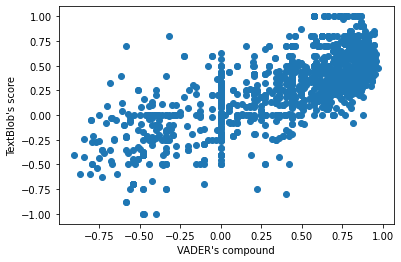

In [ ]:
from matplotlib import pyplot as plt
plt.scatter(lbm_data.compound, lbm_data.polarity)
plt.xlabel("VADER's compound")
plt.ylabel("TextBlob's score")
plt.show()

[Text(0, 0.5, 'SentiWordNet Scores'), Text(0.5, 0, 'TextBlob Scores')]

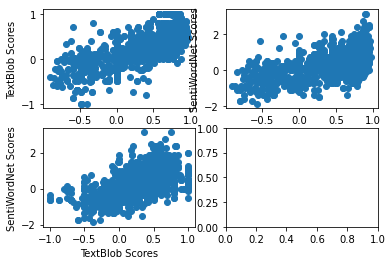

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(lbm_data.compound, lbm_data.polarity)
axs[0, 0].set(xlabel='VADER Compounds', ylabel='TextBlob Scores')
axs[0, 1].scatter(lbm_data.compound, lbm_data.senti_score)
axs[0, 1].set(xlabel='VADER Compounds', ylabel='SentiWordNet Scores')
axs[1, 0].scatter(lbm_data.polarity, lbm_data.senti_score)
axs[1, 0].set(xlabel='TextBlob Scores', ylabel='SentiWordNet Scores')

### TextBlob

In [ ]:
#Create a function to get the polarity
def getPolarity(text):
   return TextBlob(text).sentiment.polarity

In [ ]:
lbm_data['polarity'] = lbm_data['coc'].apply(lambda coc: getPolarity(coc))
pred = []
for i in range(len(lbm_data)):
        if (lbm_data['polarity'][i])>0:
            pred.append('1')
        elif (lbm_data['polarity'][i])<0:
            pred.append('-1')
        else:
            pred.append('0')
lbm_data['pred'] = pred
lbm_data.head()

,id,text,aspectTerm,From,To,SP,text_wo_sw,coc,scores,compound,true,pred,polarity
0,142087,I am very satisfied with it ... I have used th...,price,82,87,positive,satisfied ... device times ... price device .....,satisfied...device times...device...can't expe...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1,0,0.000
1,142089,"Cheap processing, wobbling unstable unstable l...",processing,6,16,negative,"cheap processing, wobbling unstable unstable l...","cheap, wobbling unstable unstable lids","{'neg': 0.625, 'neu': 0.375, 'pos': 0.0, 'comp...",-0.6124,-1,1,0.400
2,142089,"Cheap processing, wobbling unstable unstable l...",lids,45,49,negative,"cheap processing, wobbling unstable unstable l...","cheap processing, wobbling unstable unstable f...","{'neg': 0.485, 'neu': 0.515, 'pos': 0.0, 'comp...",-0.6808,-1,1,0.325
3,142089,"Cheap processing, wobbling unstable unstable l...",baking time,142,153,negative,"cheap processing, wobbling unstable unstable l...",independently time open incredible unreasonabl...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-1,1,0.225
4,142091,"The iron does not remain, the waffles are too ...",waffles,30,37,negative,"iron remain, waffles small waffles brown, six.","iron remain, small waffles brown, six.","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-1,-1,-0.250


In [ ]:
print('accuracy')
print(accuracy_score(lbm_data.true, lbm_data.pred))
print('f1 score')
print(f1_score(lbm_data.true, lbm_data.pred,average='weighted'))
print('recall')
print(recall_score(lbm_data.true, lbm_data.pred,average='weighted'))
print('precision')
print(precision_score(lbm_data.true, lbm_data.pred,average='weighted'))

accuracy
0.7080385852090032
f1 score
0.694932448305261
recall
0.7080385852090032
precision
0.7308192244540054


In [ ]:
print(classification_report(lbm_data.pred, lbm_data.true))

              precision    recall  f1-score   support

          -1       0.44      0.85      0.58       247
           0       0.20      0.17      0.18       163
           1       0.92      0.76      0.83      1145

    accuracy                           0.71      1555
   macro avg       0.52      0.59      0.53      1555
weighted avg       0.77      0.71      0.72      1555



### SentiWordNet

In [ ]:
lemmatizer = WordNetLemmatizer()
def Lemmatization(data,name):
    def getting2(sen):
        
        example = sen
        output_sentence =[]
        word_tokens2 = word_tokenize(example)
        lemmatized_output = [lemmatizer.lemmatize(w) for w in word_tokens2]
        
        # Remove characters which have length less than 2  
        without_single_chr = [word for word in lemmatized_output if len(word) > 2]
        # Remove numbers
        cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]
        
        return cleaned_data_title
    # Using "getting2(sen)" function to append edited sentence to data
    x=[]
    for i in data[name].values:
        x.append(getting2(i))
    data[name]=x

In [ ]:
from nltk.tokenize import word_tokenize 
pos=neg=obj=count=0

postagging = []

for review in lbm_data['coc']:
    list = word_tokenize(review)
    postagging.append(nltk.pos_tag(list))

lbm_data['pos_tags'] = postagging

def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None


# Returns list of pos-neg and objective score. But returns empty list if not present in senti wordnet.
def get_sentiment(word,tag):
    wn_tag = penn_to_wn(tag)
    
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []

    #Lemmatization
    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []

    #Synset is a special kind of a simple interface that is present in NLTK to look up words in WordNet. 
    #Synset instances are the groupings of synonymous words that express the same concept. 
    #Some of the words have only one Synset and some have several.
    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

    pos=neg=obj=count=0
    
    ###################################################################################
senti_score = []

for pos_val in lbm_data['pos_tags']:
    senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
    for score in senti_val:
        try:
            pos = pos + score[1]  #positive score is stored at 2nd position
            neg = neg + score[2]  #negative score is stored at 3rd position
        except:
            continue
    senti_score.append(pos - neg)
    pos=neg=0    
    
lbm_data['senti_score'] = senti_score
#print(lbm_data['senti_score'])

lbm_data.head()

,id,text,aspectTerm,From,To,SP,text_wo_sw,coc,scores,compound,true,pred,polarity,pos_tags,senti_score
0,142087,I am very satisfied with it ... I have used th...,price,82,87,positive,satisfied ... device times ... price device .....,satisfied...device times...device...can't expe...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1,0,0.000,"[(satisfied, JJ), (..., :), (device, NN), (tim...",0.875
1,142089,"Cheap processing, wobbling unstable unstable l...",processing,6,16,negative,"cheap processing, wobbling unstable unstable l...","cheap, wobbling unstable unstable lids","{'neg': 0.625, 'neu': 0.375, 'pos': 0.0, 'comp...",-0.6124,-1,1,0.400,"[(cheap, RB), (,, ,), (wobbling, VBG), (unstab...",-0.250
2,142089,"Cheap processing, wobbling unstable unstable l...",lids,45,49,negative,"cheap processing, wobbling unstable unstable l...","cheap processing, wobbling unstable unstable f...","{'neg': 0.485, 'neu': 0.515, 'pos': 0.0, 'comp...",-0.6808,-1,1,0.325,"[(cheap, JJ), (processing, NN), (,, ,), (wobbl...",-1.000
3,142089,"Cheap processing, wobbling unstable unstable l...",baking time,142,153,negative,"cheap processing, wobbling unstable unstable l...",independently time open incredible unreasonabl...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-1,1,0.225,"[(independently, RB), (time, NN), (open, JJ), ...",-0.750
4,142091,"The iron does not remain, the waffles are too ...",waffles,30,37,negative,"iron remain, waffles small waffles brown, six.","iron remain, small waffles brown, six.","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-1,-1,-0.250,"[(iron, NN), (remain, NN), (,, ,), (small, JJ)...",-0.375


In [ ]:
pred = []
for i in range(len(lbm_data)):
        if (lbm_data['senti_score'][i])>=0.05:
            pred.append('1')
        elif (lbm_data['senti_score'][i])<= -0.05:
            pred.append('-1')
        else:
            pred.append('0')
lbm_data['pred'] = pred

In [ ]:
print('accuracy')
print(accuracy_score(lbm_data.true, lbm_data.pred))
print('f1 score')
print(f1_score(lbm_data.true, lbm_data.pred,average='macro'))
print('recall')
print(recall_score(lbm_data.true, lbm_data.pred,average='macro'))
print('precision')
print(precision_score(lbm_data.true, lbm_data.pred,average='macro'))

accuracy
0.6083601286173633
f1 score
0.4683292838690701
recall
0.4686373507848824
precision
0.4832129513277263


In [ ]:
print(classification_report(lbm_data.pred, lbm_data.true))

              precision    recall  f1-score   support

          -1       0.45      0.59      0.51       364
           0       0.21      0.12      0.15       251
           1       0.75      0.75      0.75       940

    accuracy                           0.61      1555
   macro avg       0.47      0.48      0.47      1555
weighted avg       0.59      0.61      0.60      1555



In [ ]:
maxValues = lbm_data.max()
print(maxValues)

id                                                        145357
text                           very good price/performance ratio
aspectTerm                                                 works
From                                                        1079
To                                                          1092
SP                                                      positive
text_wo_sw                works well. makes cute little waffles.
coc                                 yet, having tested others!;)
compound                                                  0.9715
true                                                           1
pred                                                           1
polarity                                                     1.0
pos_tags       [(yet, RB), (,, ,), (having, VBG), (tested, VB...
senti_score                                                3.125
dtype: object


<ipython-input-44-1715b4ca6174>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  maxValues = lbm_data.max()


## ML


Train Test Split

### Logistic Regression

In [ ]:
#from sklearn.utils.class_weight import compute_class_weight
#sklearn_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
#sklearn_weights

In [ ]:
w = {'positive':0.566, 'negative':1.051, 'neutral':3.521}

Creating a dictionary with the hyperparameters

In [ ]:
# parameter grid
params = {
    'max_iter': [100,200,300],
    'penalty' : ['l1','l2','elastic','None'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear','saga','sag'],
    'verbose' : [1]
}

In [ ]:
lr=LogisticRegression(random_state=29, multi_class = 'multinomial', class_weight =w)
lr_rs=RandomizedSearchCV(lr, params, cv=10, random_state = 29, scoring='f1_macro')
lr_rs.fit(X_train, y_train)

convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
convergence after 16 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
convergence after 16 epochs took 0 seconds
convergence after 16 epochs took 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 438, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got None.

  warnings.warn("Estimator fit failed. The score on this train-test"
/usr/local/lib/python3.8/dist-packages/sklearn/model_selectio

convergence after 16 epochs took 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 1 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 1 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit

convergence after 17 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


RandomizedSearchCV(cv=10,
                   estimator=LogisticRegression(class_weight={'negative': 1.051,
                                                              'neutral': 3.521,
                                                              'positive': 0.566},
                                                multi_class='multinomial',
                                                random_state=29),
                   param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'max_iter': [100, 200, 300],
                                        'penalty': ['l1', 'l2', 'elastic',
                                                    'None'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'saga', 'sag'],
                                        'verbose': [1]},
                   random_state=29, scoring='f1_macro')

In [ ]:
print("tuned hpyerparameters :(best parameters) ",lr_rs.best_params_)
print("f1_macro :",lr_rs.best_score_)

tuned hpyerparameters :(best parameters)  {'verbose': 1, 'solver': 'sag', 'penalty': 'l2', 'max_iter': 100, 'C': 0.1}
f1_macro : 0.554586858982507


In [ ]:
predict_result_aspect = lr_rs.predict(X_test)

In [ ]:
print('accuracy')
print(accuracy_score(y_test, predict_result_aspect))
print('f1 score')
print(f1_score(y_test, predict_result_aspect,average='weighted'))
print('recall')
print(recall_score(y_test, predict_result_aspect,average='weighted'))
print('precision')
print(precision_score(y_test, predict_result_aspect,average='weighted'))



accuracy
0.7109207708779444
f1 score
0.7292850808070249
recall
0.7109207708779444
precision
0.762156511636159


In [ ]:
print(classification_report(predict_result_aspect, y_test))

              precision    recall  f1-score   support

    negative       0.72      0.59      0.65       158
     neutral       0.34      0.21      0.26        57
    positive       0.75      0.90      0.82       252

    accuracy                           0.71       467
   macro avg       0.60      0.57      0.58       467
weighted avg       0.69      0.71      0.69       467



### Random Forest

In [ ]:
# parameter grid
params= {'n_estimators': [100,500,1000],
               'max_features': ['auto', 'log2'],
               'max_depth': np.arange(2,5,1),
               'min_samples_split': np.arange(2,5,1),
               'min_samples_leaf': np.arange(1,4,1),
               'bootstrap': [True, False],
                'verbose':[1]}

In [ ]:
rf = RandomForestClassifier(random_state=29, criterion = 'entropy', class_weight =w)
rf_rs=RandomizedSearchCV(rf, params, cv=10, random_state = 29,scoring='f1_macro')
rf_rs.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(class_weight={'negative': 1.051,
                                                                  'neutral': 3.521,
                                                                  'positive': 0.566},
                                                    criterion='entropy',
                                                    random_state=29),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([2, 3, 4]),
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': array([1, 2, 3]),
                                        'min_samples_split': array([2, 3, 4]),
                                        'n_estimators': [100, 500, 1000],
                                        'verbose': [1]},
                   random_state=29, scoring='f1_macro')

In [ ]:
print("tuned hpyerparameters :(best parameters) ",rf_rs.best_params_)
print("f1_macro :",rf_rs.best_score_)

tuned hpyerparameters :(best parameters)  {'verbose': 1, 'n_estimators': 1000, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 3, 'bootstrap': False}
f1_macro : 0.5473215959193335


In [ ]:
predict_result_aspect = rf_rs.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


In [ ]:
print('accuracy')
print(accuracy_score(y_test, predict_result_aspect))
print('f1 score')
print(f1_score(y_test, predict_result_aspect,average='weighted'))
print('recall')
print(recall_score(y_test, predict_result_aspect,average='weighted'))
print('precision')
print(precision_score(y_test, predict_result_aspect,average='weighted'))


accuracy
0.7002141327623126
f1 score
0.7110787869818663
recall
0.7002141327623126
precision
0.7310551495941402


In [ ]:
print(classification_report(predict_result_aspect, y_test))

              precision    recall  f1-score   support

    negative       0.72      0.58      0.64       159
     neutral       0.26      0.20      0.23        45
    positive       0.75      0.86      0.80       263

    accuracy                           0.70       467
   macro avg       0.57      0.55      0.56       467
weighted avg       0.69      0.70      0.69       467



### Multinomial NB 

In [ ]:
# parameter grid
params = {
  'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
  'fit_prior': [True, False]
}

In [ ]:
mnb = MultinomialNB()
mnb_rs=RandomizedSearchCV(mnb, params, cv=10, random_state = 29,scoring='f1_macro')
mnb_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=MultinomialNB(),
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100, 1000],
                                        'fit_prior': [True, False]},
                   random_state=29, scoring='f1_macro')

In [ ]:
print("tuned hpyerparameters :(best parameters) ",mnb_rs.best_params_)
print("f1_macro :",mnb_rs.best_score_)

tuned hpyerparameters :(best parameters)  {'fit_prior': True, 'alpha': 0.1}
f1_macro : 0.5360826960818954


In [ ]:
predict_result_aspect = mnb_rs.predict(X_test)

In [ ]:
print('accuracy')
print(accuracy_score(y_test, predict_result_aspect))
print('f1 score')
print(f1_score(y_test, predict_result_aspect,average='weighted'))
print('recall')
print(recall_score(y_test, predict_result_aspect,average='weighted'))
print('precision')
print(precision_score(y_test, predict_result_aspect,average='weighted'))


accuracy
0.715203426124197
f1 score
0.6873204383265501
recall
0.715203426124197
precision
0.6778227177757392


In [ ]:
print(classification_report(predict_result_aspect, y_test))

              precision    recall  f1-score   support

    negative       0.49      0.62      0.55       103
     neutral       0.06      0.22      0.09         9
    positive       0.89      0.75      0.82       355

    accuracy                           0.72       467
   macro avg       0.48      0.53      0.49       467
weighted avg       0.78      0.72      0.74       467



### SVM

In [ ]:
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "elasticnet","none"],
    'verbose' :[1]
}

In [ ]:

svm = SGDClassifier(random_state=29, class_weight =w)
svm_rs=RandomizedSearchCV(svm, params, cv=10, random_state = 29,scoring='f1_macro')
svm_rs.fit(X_train, y_train)

-- Epoch 1
Norm: 7.11, NNZs: 338, Bias: -0.115027, T: 979, Avg. loss: 0.643936
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 6.16, NNZs: 225, Bias: -0.114849, T: 1958, Avg. loss: 0.547316
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 5.82, NNZs: 247, Bias: -0.116922, T: 2937, Avg. loss: 0.541444
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 5.66, NNZs: 251, Bias: -0.123421, T: 3916, Avg. loss: 0.535785
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 5.55, NNZs: 257, Bias: -0.122840, T: 4895, Avg. loss: 0.530856
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 5.47, NNZs: 259, Bias: -0.121635, T: 5874, Avg. loss: 0.528370
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 5.42, NNZs: 261, Bias: -0.122666, T: 6853, Avg. loss: 0.527197
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 5.38, NNZs: 262, Bias: -0.123178, T: 7832, Avg. loss: 0.525774
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 5.35, NNZs: 263, Bias: -0.123560, T: 8811, Avg. loss: 0.524745
T

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 3
Norm: 5.77, NNZs: 250, Bias: -0.118545, T: 2937, Avg. loss: 0.555601
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 5.61, NNZs: 262, Bias: -0.124509, T: 3916, Avg. loss: 0.548671
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 5.49, NNZs: 265, Bias: -0.124365, T: 4895, Avg. loss: 0.543209
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 5.41, NNZs: 274, Bias: -0.123427, T: 5874, Avg. loss: 0.541439
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 5.36, NNZs: 284, Bias: -0.123459, T: 6853, Avg. loss: 0.538799
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 5.33, NNZs: 283, Bias: -0.124336, T: 7832, Avg. loss: 0.537404
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 5.31, NNZs: 293, Bias: -0.125232, T: 8811, Avg. loss: 0.536005
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 5.29, NNZs: 293, Bias: -0.125540, T: 9790, Avg. loss: 0.534548
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 5.27, NNZs: 294, Bias: -0.125343, T: 10769, Avg. loss: 0.5332

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 17
Norm: 4.59, NNZs: 204, Bias: -0.296106, T: 16643, Avg. loss: 0.674866
Total training time: 0.03 seconds.
Convergence after 17 epochs took 0.03 seconds
-- Epoch 1
Norm: 7.00, NNZs: 329, Bias: -0.113145, T: 979, Avg. loss: 0.640757
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 6.14, NNZs: 218, Bias: -0.115318, T: 1958, Avg. loss: 0.550881
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 5.79, NNZs: 231, Bias: -0.115054, T: 2937, Avg. loss: 0.545667
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 5.63, NNZs: 243, Bias: -0.119084, T: 3916, Avg. loss: 0.538830
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 5.53, NNZs: 253, Bias: -0.120768, T: 4895, Avg. loss: 0.533490
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 5.46, NNZs: 262, Bias: -0.119991, T: 5874, Avg. loss: 0.531212
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 5.42, NNZs: 263, Bias: -0.121375, T: 6853, Avg. loss: 0.528718
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 5.39, NNZs: 264,

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 9
Norm: 13.28, NNZs: 1280, Bias: -0.136204, T: 8811, Avg. loss: 0.369686
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 13.40, NNZs: 1280, Bias: -0.135597, T: 9790, Avg. loss: 0.367349
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 13.51, NNZs: 1280, Bias: -0.135060, T: 10769, Avg. loss: 0.365278
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 13.61, NNZs: 1280, Bias: -0.134560, T: 11748, Avg. loss: 0.363443
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 13.70, NNZs: 1280, Bias: -0.134108, T: 12727, Avg. loss: 0.361783
Total training time: 0.01 seconds.
-- Epoch 14
Norm: 13.78, NNZs: 1280, Bias: -0.133690, T: 13706, Avg. loss: 0.360271
Total training time: 0.01 seconds.
-- Epoch 15
Norm: 13.86, NNZs: 1280, Bias: -0.133312, T: 14685, Avg. loss: 0.358886
Total training time: 0.01 seconds.
-- Epoch 16
Norm: 13.93, NNZs: 1280, Bias: -0.132953, T: 15664, Avg. loss: 0.357614
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 13.99, NNZs: 1280, Bias: -0.13263

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 11.99, NNZs: 1291, Bias: -0.238830, T: 22517, Avg. loss: 0.415330
Total training time: 0.02 seconds.
-- Epoch 24
Norm: 12.04, NNZs: 1291, Bias: -0.239721, T: 23496, Avg. loss: 0.414585
Total training time: 0.02 seconds.
-- Epoch 25
Norm: 12.08, NNZs: 1291, Bias: -0.240571, T: 24475, Avg. loss: 0.413803
Total training time: 0.03 seconds.
Convergence after 25 epochs took 0.03 seconds
-- Epoch 1
Norm: 10.67, NNZs: 1328, Bias: -0.160935, T: 979, Avg. loss: 0.501651
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 11.48, NNZs: 1328, Bias: -0.156235, T: 1958, Avg. loss: 0.419918
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 11.95, NNZs: 1328, Bias: -0.153681, T: 2937, Avg. loss: 0.403475
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 12.29, NNZs: 1328, Bias: -0.151378, T: 3916, Avg. loss: 0.394285
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 12.55, NNZs: 1328, Bias: -0.149693, T: 4895, Avg. loss: 0.387888
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 12.76, N

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 8
Norm: 15.16, NNZs: 1325, Bias: -0.438039, T: 7832, Avg. loss: 0.283127
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 15.30, NNZs: 1325, Bias: -0.442362, T: 8811, Avg. loss: 0.279849
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 15.42, NNZs: 1325, Bias: -0.446149, T: 9790, Avg. loss: 0.277858
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 15.53, NNZs: 1325, Bias: -0.449509, T: 10769, Avg. loss: 0.276184
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 15.63, NNZs: 1325, Bias: -0.452600, T: 11748, Avg. loss: 0.274102
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 15.72, NNZs: 1325, Bias: -0.455426, T: 12727, Avg. loss: 0.272334
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 15.81, NNZs: 1325, Bias: -0.458020, T: 13706, Avg. loss: 0.271026
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 15.88, NNZs: 1325, Bias: -0.460406, T: 14685, Avg. loss: 0.269771
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 15.96, NNZs: 1325, Bias: -0.462631,

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


-- Epoch 4
Norm: 10.05, NNZs: 1338, Bias: -0.173950, T: 3920, Avg. loss: 0.462521
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 10.31, NNZs: 1338, Bias: -0.179322, T: 4900, Avg. loss: 0.455676
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 10.51, NNZs: 1338, Bias: -0.183623, T: 5880, Avg. loss: 0.450373
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 10.69, NNZs: 1338, Bias: -0.187100, T: 6860, Avg. loss: 0.446013
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 10.83, NNZs: 1338, Bias: -0.190064, T: 7840, Avg. loss: 0.442545
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 10.96, NNZs: 1338, Bias: -0.192675, T: 8820, Avg. loss: 0.439613
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 11.08, NNZs: 1338, Bias: -0.194987, T: 9800, Avg. loss: 0.437110
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 11.18, NNZs: 1338, Bias: -0.197063, T: 10780, Avg. loss: 0.434903
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 11.28, NNZs: 1338, Bias: -0.198928, T: 1176

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 8
Norm: 71.80, NNZs: 195, Bias: -1.002518, T: 7832, Avg. loss: 0.149270
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 72.17, NNZs: 189, Bias: -1.005257, T: 8811, Avg. loss: 0.143723
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 72.53, NNZs: 187, Bias: -1.002056, T: 9790, Avg. loss: 0.139848
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 72.85, NNZs: 184, Bias: -1.019403, T: 10769, Avg. loss: 0.137892
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 73.13, NNZs: 185, Bias: -1.002633, T: 11748, Avg. loss: 0.135515
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 73.44, NNZs: 188, Bias: -1.003604, T: 12727, Avg. loss: 0.135488
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 73.68, NNZs: 186, Bias: -1.001970, T: 13706, Avg. loss: 0.134613
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 73.92, NNZs: 188, Bias: -1.001655, T: 14685, Avg. loss: 0.132495
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 74.11, NNZs: 187, Bias: -1.010842, T: 15664

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 49.69, NNZs: 344, Bias: -0.136518, T: 979, Avg. loss: 0.535491
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 53.01, NNZs: 204, Bias: -0.160879, T: 1958, Avg. loss: 0.347216
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 54.80, NNZs: 194, Bias: -0.162166, T: 2937, Avg. loss: 0.357428
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 55.94, NNZs: 189, Bias: -0.201522, T: 3916, Avg. loss: 0.346535
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 56.80, NNZs: 183, Bias: -0.198253, T: 4895, Avg. loss: 0.336430
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 57.47, NNZs: 180, Bias: -0.198101, T: 5874, Avg. loss: 0.332516
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 58.01, NNZs: 181, Bias: -0.219732, T: 6853, Avg. loss: 0.327069
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 58.48, NNZs: 179, Bias: -0.212675, T: 7832, Avg. loss: 0.324022
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 58.88, NNZs: 179, Bias: -0.223895, T: 8811, Avg. loss: 0

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 49.43, NNZs: 361, Bias: -0.026323, T: 980, Avg. loss: 0.527671
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 52.90, NNZs: 209, Bias: 0.013049, T: 1960, Avg. loss: 0.339346
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 54.76, NNZs: 200, Bias: -0.060283, T: 2940, Avg. loss: 0.351411
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 55.89, NNZs: 195, Bias: -0.076486, T: 3920, Avg. loss: 0.339158
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 56.76, NNZs: 188, Bias: -0.087673, T: 4900, Avg. loss: 0.333607
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 57.41, NNZs: 188, Bias: -0.077601, T: 5880, Avg. loss: 0.326620
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 57.96, NNZs: 184, Bias: -0.082017, T: 6860, Avg. loss: 0.323186
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 58.41, NNZs: 185, Bias: -0.097395, T: 7840, Avg. loss: 0.320428
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 58.82, NNZs: 186, Bias: -0.100499, T: 8820, Avg. loss: 0.

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 4
Norm: 85.95, NNZs: 1291, Bias: -0.264931, T: 3916, Avg. loss: 0.072030
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 87.69, NNZs: 1291, Bias: -0.195965, T: 4895, Avg. loss: 0.063493
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 89.08, NNZs: 1291, Bias: -0.208979, T: 5874, Avg. loss: 0.058357
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 90.25, NNZs: 1291, Bias: -0.213611, T: 6853, Avg. loss: 0.054286
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 91.25, NNZs: 1291, Bias: -0.224664, T: 7832, Avg. loss: 0.051709
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 92.11, NNZs: 1291, Bias: -0.249180, T: 8811, Avg. loss: 0.049561
Total training time: 0.02 seconds.
-- Epoch 10
Norm: 92.87, NNZs: 1291, Bias: -0.252222, T: 9790, Avg. loss: 0.047958
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 93.55, NNZs: 1291, Bias: -0.252969, T: 10769, Avg. loss: 0.046592
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 94.16, NNZs: 1291, Bias: -0.251958, T: 1174

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 140.12, NNZs: 1329, Bias: -2.413506, T: 4895, Avg. loss: 0.039327
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 140.43, NNZs: 1329, Bias: -2.464948, T: 5874, Avg. loss: 0.034940
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 140.74, NNZs: 1329, Bias: -2.489263, T: 6853, Avg. loss: 0.030699
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 140.95, NNZs: 1329, Bias: -2.532579, T: 7832, Avg. loss: 0.029893
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 141.21, NNZs: 1329, Bias: -2.540444, T: 8811, Avg. loss: 0.026765
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 141.42, NNZs: 1329, Bias: -2.552241, T: 9790, Avg. loss: 0.025704
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 141.65, NNZs: 1329, Bias: -2.551069, T: 10769, Avg. loss: 0.024239
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 141.80, NNZs: 1329, Bias: -2.570169, T: 11748, Avg. loss: 0.025202
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 141.99, NNZs: 1329, Bias: -2.567526, T: 1272

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 95.52, NNZs: 1325, Bias: -0.340273, T: 16643, Avg. loss: 0.046013
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 95.90, NNZs: 1325, Bias: -0.344312, T: 17622, Avg. loss: 0.045451
Total training time: 0.02 seconds.
Convergence after 18 epochs took 0.02 seconds
-- Epoch 1
Norm: 137.04, NNZs: 1325, Bias: -0.868464, T: 979, Avg. loss: 0.820197
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 137.03, NNZs: 1325, Bias: -2.369992, T: 1958, Avg. loss: 0.304354
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 138.17, NNZs: 1325, Bias: -2.335183, T: 2937, Avg. loss: 0.129061
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 137.94, NNZs: 1325, Bias: -2.647115, T: 3916, Avg. loss: 0.072217
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 138.48, NNZs: 1325, Bias: -2.653766, T: 4895, Avg. loss: 0.050707
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 138.74, NNZs: 1325, Bias: -2.710435, T: 5874, Avg. loss: 0.042972
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 139.

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 39
Norm: 910552.11, NNZs: 926, Bias: -11089.821681, T: 38181, Avg. loss: 20.797761
Total training time: 0.04 seconds.
-- Epoch 40
Norm: 910552.00, NNZs: 926, Bias: -11089.914239, T: 39160, Avg. loss: 18.654686
Total training time: 0.04 seconds.
-- Epoch 41
Norm: 910551.89, NNZs: 926, Bias: -11090.001359, T: 40139, Avg. loss: 16.800858
Total training time: 0.04 seconds.
-- Epoch 42
Norm: 910551.79, NNZs: 926, Bias: -11090.080019, T: 41118, Avg. loss: 15.152164
Total training time: 0.04 seconds.
-- Epoch 43
Norm: 910551.70, NNZs: 926, Bias: -11090.153179, T: 42097, Avg. loss: 13.709435
Total training time: 0.04 seconds.
-- Epoch 44
Norm: 910551.62, NNZs: 926, Bias: -11090.219669, T: 43076, Avg. loss: 12.437304
Total training time: 0.05 seconds.
-- Epoch 45
Norm: 910551.55, NNZs: 926, Bias: -11090.281943, T: 44055, Avg. loss: 11.306136
Total training time: 0.05 seconds.
-- Epoch 46
Norm: 910551.47, NNZs: 926, Bias: -11090.340160, T: 45034, Avg. loss: 10.293995
Total training time

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 1105.29, NNZs: 806, Bias: -1.173451, T: 3916, Avg. loss: 4.719774
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 1104.57, NNZs: 806, Bias: -1.099916, T: 4895, Avg. loss: 2.757832
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 1104.15, NNZs: 804, Bias: -1.082595, T: 5874, Avg. loss: 1.895800
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 1103.87, NNZs: 802, Bias: -1.128957, T: 6853, Avg. loss: 1.441822
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 1103.67, NNZs: 795, Bias: -1.181774, T: 7832, Avg. loss: 1.136727
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 1103.53, NNZs: 793, Bias: -1.223131, T: 8811, Avg. loss: 0.938318
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 1103.42, NNZs: 790, Bias: -1.234737, T: 9790, Avg. loss: 0.802611
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 1103.34, NNZs: 789, Bias: -1.240444, T: 10769, Avg. loss: 0.699975
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 1103.28, NNZs: 788, Bias: -1.259296, T: 11748,

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 41
Norm: 1078.57, NNZs: 729, Bias: -1.275154, T: 40139, Avg. loss: 0.342013
Total training time: 0.04 seconds.
-- Epoch 42
Norm: 1078.56, NNZs: 729, Bias: -1.276028, T: 41118, Avg. loss: 0.336874
Total training time: 0.04 seconds.
-- Epoch 43
Norm: 1078.55, NNZs: 729, Bias: -1.276847, T: 42097, Avg. loss: 0.331231
Total training time: 0.04 seconds.
-- Epoch 44
Norm: 1078.54, NNZs: 729, Bias: -1.277692, T: 43076, Avg. loss: 0.326665
Total training time: 0.04 seconds.
-- Epoch 45
Norm: 1078.53, NNZs: 729, Bias: -1.278296, T: 44055, Avg. loss: 0.321710
Total training time: 0.04 seconds.
-- Epoch 46
Norm: 1078.52, NNZs: 729, Bias: -1.279235, T: 45034, Avg. loss: 0.317548
Total training time: 0.04 seconds.
-- Epoch 47
Norm: 1078.52, NNZs: 727, Bias: -1.280000, T: 46013, Avg. loss: 0.313057
Total training time: 0.04 seconds.
-- Epoch 48
Norm: 1078.51, NNZs: 727, Bias: -1.279846, T: 46992, Avg. loss: 0.308593
Total training time: 0.05 seconds.
-- Epoch 49
Norm: 1078.50, NNZs: 727, Bi

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s finished
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 1157.08, NNZs: 748, Bias: -0.902407, T: 101816, Avg. loss: 0.236594
Total training time: 0.14 seconds.
-- Epoch 105
Norm: 1157.08, NNZs: 748, Bias: -0.902439, T: 102795, Avg. loss: 0.235467
Total training time: 0.15 seconds.
-- Epoch 106
Norm: 1157.07, NNZs: 748, Bias: -0.902479, T: 103774, Avg. loss: 0.234099
Total training time: 0.15 seconds.
-- Epoch 107
Norm: 1157.07, NNZs: 747, Bias: -0.902547, T: 104753, Avg. loss: 0.232823
Total training time: 0.15 seconds.
-- Epoch 108
Norm: 1157.07, NNZs: 747, Bias: -0.902683, T: 105732, Avg. loss: 0.231863
Total training time: 0.15 seconds.
-- Epoch 109
Norm: 1157.07, NNZs: 747, Bias: -0.902868, T: 106711, Avg. loss: 0.230722
Total training time: 0.15 seconds.
-- Epoch 110
Norm: 1157.07, NNZs: 747, Bias: -0.902944, T: 107690, Avg. loss: 0.229458
Total training time: 0.15 seconds.
-- Epoch 111
Norm: 1157.06, NNZs: 747, Bias: -0.902944, T: 108669, Avg. loss: 0.228343
Total training time: 0.15 seconds.
-- Epoch 112
Norm: 1157.06, NNZs: 747

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 68
Norm: 1141.49, NNZs: 782, Bias: -1.917740, T: 66572, Avg. loss: 0.163934
Total training time: 0.08 seconds.
-- Epoch 69
Norm: 1141.49, NNZs: 782, Bias: -1.918965, T: 67551, Avg. loss: 0.162550
Total training time: 0.08 seconds.
-- Epoch 70
Norm: 1141.49, NNZs: 782, Bias: -1.920021, T: 68530, Avg. loss: 0.161405
Total training time: 0.08 seconds.
-- Epoch 71
Norm: 1141.49, NNZs: 782, Bias: -1.921152, T: 69509, Avg. loss: 0.160239
Total training time: 0.08 seconds.
-- Epoch 72
Norm: 1141.49, NNZs: 782, Bias: -1.922351, T: 70488, Avg. loss: 0.159197
Total training time: 0.09 seconds.
-- Epoch 73
Norm: 1141.49, NNZs: 782, Bias: -1.923487, T: 71467, Avg. loss: 0.157879
Total training time: 0.09 seconds.
-- Epoch 74
Norm: 1141.48, NNZs: 780, Bias: -1.924559, T: 72446, Avg. loss: 0.156649
Total training time: 0.09 seconds.
-- Epoch 75
Norm: 1141.48, NNZs: 779, Bias: -1.925608, T: 73425, Avg. loss: 0.155576
Total training time: 0.09 seconds.
-- Epoch 76
Norm: 1141.48, NNZs: 779, Bi

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 150222.30, NNZs: 920, Bias: -1591.204931, T: 33286, Avg. loss: 253.763385
Total training time: 0.18 seconds.
-- Epoch 35
Norm: 150222.15, NNZs: 920, Bias: -1591.251412, T: 34265, Avg. loss: 232.850402
Total training time: 0.18 seconds.
-- Epoch 36
Norm: 150221.93, NNZs: 920, Bias: -1591.369795, T: 35244, Avg. loss: 245.474446
Total training time: 0.18 seconds.
-- Epoch 37
Norm: 150221.72, NNZs: 920, Bias: -1591.477665, T: 36223, Avg. loss: 240.250800
Total training time: 0.18 seconds.
-- Epoch 38
Norm: 150221.58, NNZs: 920, Bias: -1591.515311, T: 37202, Avg. loss: 222.292318
Total training time: 0.18 seconds.
-- Epoch 39
Norm: 150221.45, NNZs: 920, Bias: -1591.563277, T: 38181, Avg. loss: 221.031121
Total training time: 0.18 seconds.
-- Epoch 40
Norm: 150221.25, NNZs: 920, Bias: -1591.664745, T: 39160, Avg. loss: 231.471256
Total training time: 0.18 seconds.
-- Epoch 41
Norm: 150221.12, NNZs: 920, Bias: -1591.710088, T: 40139, Avg. loss: 214.925079
Total training time: 0.18 secon

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 2228.17, NNZs: 891, Bias: -1.900465, T: 100837, Avg. loss: 0.558069
Total training time: 0.08 seconds.
-- Epoch 104
Norm: 2228.16, NNZs: 891, Bias: -1.899832, T: 101816, Avg. loss: 0.555332
Total training time: 0.09 seconds.
-- Epoch 105
Norm: 2228.16, NNZs: 891, Bias: -1.899252, T: 102795, Avg. loss: 0.552353
Total training time: 0.09 seconds.
-- Epoch 106
Norm: 2228.16, NNZs: 890, Bias: -1.898591, T: 103774, Avg. loss: 0.549354
Total training time: 0.09 seconds.
-- Epoch 107
Norm: 2228.15, NNZs: 890, Bias: -1.898004, T: 104753, Avg. loss: 0.546552
Total training time: 0.09 seconds.
-- Epoch 108
Norm: 2228.15, NNZs: 890, Bias: -1.897327, T: 105732, Avg. loss: 0.543736
Total training time: 0.09 seconds.
-- Epoch 109
Norm: 2228.15, NNZs: 890, Bias: -1.896725, T: 106711, Avg. loss: 0.540657
Total training time: 0.09 seconds.
-- Epoch 110
Norm: 2228.14, NNZs: 889, Bias: -1.896046, T: 107690, Avg. loss: 0.538093
Total training time: 0.09 seconds.
-- Epoch 111
Norm: 2228.14, NNZs: 889

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 105
Norm: 32190.63, NNZs: 937, Bias: -482.694652, T: 102795, Avg. loss: 34.836801
Total training time: 0.09 seconds.
-- Epoch 106
Norm: 32190.59, NNZs: 937, Bias: -482.701390, T: 103774, Avg. loss: 33.892363
Total training time: 0.10 seconds.
-- Epoch 107
Norm: 32190.55, NNZs: 937, Bias: -482.711305, T: 104753, Avg. loss: 34.489200
Total training time: 0.10 seconds.
-- Epoch 108
Norm: 32190.52, NNZs: 937, Bias: -482.720921, T: 105732, Avg. loss: 34.291877
Total training time: 0.10 seconds.
-- Epoch 109
Norm: 32190.49, NNZs: 937, Bias: -482.727019, T: 106711, Avg. loss: 33.392747
Total training time: 0.10 seconds.
-- Epoch 110
Norm: 32190.45, NNZs: 937, Bias: -482.736126, T: 107690, Avg. loss: 33.975161
Total training time: 0.10 seconds.
-- Epoch 111
Norm: 32190.42, NNZs: 937, Bias: -482.745705, T: 108669, Avg. loss: 33.811942
Total training time: 0.10 seconds.
-- Epoch 112
Norm: 32190.38, NNZs: 937, Bias: -482.754562, T: 109648, Avg. loss: 33.616747
Total training time: 0.10 s

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 1093.13, NNZs: 796, Bias: -6.006795, T: 980, Avg. loss: 355.287983
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 1026.61, NNZs: 853, Bias: -2.287448, T: 1960, Avg. loss: 194.520260
Total training time: 0.12 seconds.
-- Epoch 3
Norm: 1022.99, NNZs: 852, Bias: -1.243928, T: 2940, Avg. loss: 9.545134
Total training time: 0.17 seconds.
-- Epoch 4
Norm: 1022.29, NNZs: 856, Bias: -1.616264, T: 3920, Avg. loss: 2.149595
Total training time: 0.17 seconds.
-- Epoch 5
Norm: 1022.04, NNZs: 850, Bias: -1.535643, T: 4900, Avg. loss: 1.117586
Total training time: 0.17 seconds.
-- Epoch 6
Norm: 1021.90, NNZs: 847, Bias: -1.501598, T: 5880, Avg. loss: 0.742371
Total training time: 0.17 seconds.
-- Epoch 7
Norm: 1021.81, NNZs: 843, Bias: -1.466998, T: 6860, Avg. loss: 0.573206
Total training time: 0.18 seconds.
-- Epoch 8
Norm: 1021.75, NNZs: 842, Bias: -1.479072, T: 7840, Avg. loss: 0.461089
Total training time: 0.18 seconds.
-- Epoch 9
Norm: 1021.70, NNZs: 836, Bias: -1.475612,

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 22
Norm: 357870.10, NNZs: 997, Bias: -5208.660399, T: 21560, Avg. loss: 14465.010959
Total training time: 0.18 seconds.
-- Epoch 23
Norm: 357863.75, NNZs: 997, Bias: -5210.420451, T: 22540, Avg. loss: 15051.341959
Total training time: 0.18 seconds.
-- Epoch 24
Norm: 357859.52, NNZs: 997, Bias: -5210.870084, T: 23520, Avg. loss: 13718.169494
Total training time: 0.18 seconds.
-- Epoch 25
Norm: 357854.00, NNZs: 997, Bias: -5212.392066, T: 24500, Avg. loss: 14201.585211
Total training time: 0.18 seconds.
-- Epoch 26
Norm: 357850.63, NNZs: 997, Bias: -5212.552843, T: 25480, Avg. loss: 12849.342807
Total training time: 0.18 seconds.
-- Epoch 27
Norm: 357846.34, NNZs: 997, Bias: -5213.497344, T: 26460, Avg. loss: 13335.981890
Total training time: 0.18 seconds.
-- Epoch 28
Norm: 357844.16, NNZs: 997, Bias: -5213.071185, T: 27440, Avg. loss: 11949.070737
Total training time: 0.18 seconds.
-- Epoch 29
Norm: 357841.83, NNZs: 997, Bias: -5212.851122, T: 28420, Avg. loss: 11859.959286
Tot

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 42
Norm: 44216979727440.88, NNZs: 1057, Bias: -131605831007.525528, T: 41118, Avg. loss: 0.027662
Total training time: 0.04 seconds.
-- Epoch 43
Norm: 44216979727440.88, NNZs: 1057, Bias: -131605831007.525391, T: 42097, Avg. loss: 0.026781
Total training time: 0.04 seconds.
-- Epoch 44
Norm: 44216979727440.87, NNZs: 1057, Bias: -131605831007.526703, T: 43076, Avg. loss: 0.026828
Total training time: 0.04 seconds.
Convergence after 44 epochs took 0.05 seconds
-- Epoch 1
Norm: 112612478706033.09, NNZs: 722, Bias: -300593000270.106628, T: 979, Avg. loss: 2346158224808556791595008.000000
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 120903255922791.41, NNZs: 842, Bias: -929697773012.792847, T: 1958, Avg. loss: 2030738790270940167012352.000000
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 121220683937153.97, NNZs: 861, Bias: -1226994422790.001709, T: 2937, Avg. loss: 511300543943911009157120.000000
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 121575508429280.98, 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 11
Norm: 119158479360112.16, NNZs: 907, Bias: -1800155012427.834961, T: 10769, Avg. loss: 8058986277598577819648.000000
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 119153643650397.73, NNZs: 907, Bias: -1797907621151.166504, T: 11748, Avg. loss: 6831373464295172997120.000000
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 119150166361029.20, NNZs: 907, Bias: -1799905004176.391602, T: 12727, Avg. loss: 5144635761592408997888.000000
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 119099842111093.19, NNZs: 907, Bias: -1823898500222.803467, T: 13706, Avg. loss: 4990081355364584914944.000000
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 119105022982482.52, NNZs: 907, Bias: -1818639808568.792725, T: 14685, Avg. loss: 2024265567381910716416.000000
Total training time: 0.03 seconds.
-- Epoch 16
Norm: 119091739488692.14, NNZs: 907, Bias: -1826982404696.637939, T: 15664, Avg. loss: 884621305192270528512.000000
Total training time: 0.03 seconds.
-- Epoch 17
Norm:

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 28
Norm: 110519822768565.91, NNZs: 962, Bias: -1812013260378.952637, T: 27412, Avg. loss: 678667.727634
Total training time: 0.03 seconds.
-- Epoch 29
Norm: 110519822768501.25, NNZs: 962, Bias: -1812013260418.396973, T: 28391, Avg. loss: 50432.795375
Total training time: 0.03 seconds.
-- Epoch 30
Norm: 110519822768454.52, NNZs: 962, Bias: -1812013260446.902100, T: 29370, Avg. loss: 6586.990188
Total training time: 0.03 seconds.
-- Epoch 31
Norm: 110519822768445.03, NNZs: 962, Bias: -1812013260452.677734, T: 30349, Avg. loss: 585.321646
Total training time: 0.03 seconds.
-- Epoch 32
Norm: 110519822768441.78, NNZs: 962, Bias: -1812013260454.660400, T: 31328, Avg. loss: 64.649866
Total training time: 0.03 seconds.
-- Epoch 33
Norm: 110519822768440.16, NNZs: 962, Bias: -1812013260455.657227, T: 32307, Avg. loss: 8.338682
Total training time: 0.03 seconds.
-- Epoch 34
Norm: 110519822768439.58, NNZs: 962, Bias: -1812013260456.005127, T: 33286, Avg. loss: 0.944623
Total training time

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 111171880662106.55, NNZs: 966, Bias: -1548028587362.632324, T: 8820, Avg. loss: 25520329339617406877696.000000
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 111140288385722.92, NNZs: 966, Bias: -1550304200752.920166, T: 9800, Avg. loss: 27685966554220961202176.000000
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 111050584433324.67, NNZs: 966, Bias: -1588617225654.631592, T: 10780, Avg. loss: 19132873558876867264512.000000
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 110992464200357.39, NNZs: 966, Bias: -1609995733879.235840, T: 11760, Avg. loss: 13510213851518154571776.000000
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 110992387909360.81, NNZs: 966, Bias: -1609918798565.267578, T: 12740, Avg. loss: 5092344054875627192320.000000
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 110975941045771.77, NNZs: 966, Bias: -1615213156951.052002, T: 13720, Avg. loss: 3924153094454724001792.000000
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 11094341

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 16
Norm: 18.88, NNZs: 1186, Bias: -0.080426, T: 15664, Avg. loss: 0.219171
Total training time: 0.03 seconds.
-- Epoch 17
Norm: 18.92, NNZs: 1187, Bias: -0.079513, T: 16643, Avg. loss: 0.217197
Total training time: 0.03 seconds.
-- Epoch 18
Norm: 18.97, NNZs: 1187, Bias: -0.079078, T: 17622, Avg. loss: 0.215397
Total training time: 0.03 seconds.
-- Epoch 19
Norm: 19.01, NNZs: 1187, Bias: -0.077934, T: 18601, Avg. loss: 0.213681
Total training time: 0.03 seconds.
-- Epoch 20
Norm: 19.04, NNZs: 1187, Bias: -0.076798, T: 19580, Avg. loss: 0.212105
Total training time: 0.03 seconds.
-- Epoch 21
Norm: 19.09, NNZs: 1187, Bias: -0.077022, T: 20559, Avg. loss: 0.210724
Total training time: 0.03 seconds.
-- Epoch 22
Norm: 19.12, NNZs: 1187, Bias: -0.075939, T: 21538, Avg. loss: 0.209267
Total training time: 0.03 seconds.
-- Epoch 23
Norm: 19.15, NNZs: 1187, Bias: -0.075485, T: 22517, Avg. loss: 0.207994
Total training time: 0.04 seconds.
-- Epoch 24
Norm: 19.19, NNZs: 1187, Bias: -0.07

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 13
Norm: 18.47, NNZs: 1194, Bias: -0.063224, T: 12727, Avg. loss: 0.226891
Total training time: 0.01 seconds.
-- Epoch 14
Norm: 18.54, NNZs: 1194, Bias: -0.062602, T: 13706, Avg. loss: 0.224172
Total training time: 0.01 seconds.
-- Epoch 15
Norm: 18.61, NNZs: 1194, Bias: -0.061746, T: 14685, Avg. loss: 0.221604
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 18.67, NNZs: 1194, Bias: -0.060656, T: 15664, Avg. loss: 0.219261
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 18.72, NNZs: 1194, Bias: -0.059819, T: 16643, Avg. loss: 0.217150
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 18.78, NNZs: 1194, Bias: -0.059357, T: 17622, Avg. loss: 0.215182
Total training time: 0.02 seconds.
-- Epoch 19
Norm: 18.82, NNZs: 1194, Bias: -0.058508, T: 18601, Avg. loss: 0.213313
Total training time: 0.02 seconds.
-- Epoch 20
Norm: 18.87, NNZs: 1195, Bias: -0.058125, T: 19580, Avg. loss: 0.211609
Total training time: 0.02 seconds.
-- Epoch 21
Norm: 18.92, NNZs: 1195, Bias: -0.05

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 19.27, NNZs: 1220, Bias: -0.063907, T: 23496, Avg. loss: 0.216563
Total training time: 0.03 seconds.
-- Epoch 25
Norm: 19.30, NNZs: 1220, Bias: -0.063020, T: 24475, Avg. loss: 0.215374
Total training time: 0.04 seconds.
-- Epoch 26
Norm: 19.33, NNZs: 1220, Bias: -0.062688, T: 25454, Avg. loss: 0.214222
Total training time: 0.04 seconds.
-- Epoch 27
Norm: 19.36, NNZs: 1220, Bias: -0.061757, T: 26433, Avg. loss: 0.213124
Total training time: 0.04 seconds.
-- Epoch 28
Norm: 19.38, NNZs: 1220, Bias: -0.061241, T: 27412, Avg. loss: 0.212062
Total training time: 0.04 seconds.
-- Epoch 29
Norm: 19.41, NNZs: 1220, Bias: -0.060453, T: 28391, Avg. loss: 0.211047
Total training time: 0.04 seconds.
-- Epoch 30
Norm: 19.43, NNZs: 1220, Bias: -0.060312, T: 29370, Avg. loss: 0.210133
Total training time: 0.05 seconds.
-- Epoch 31
Norm: 19.46, NNZs: 1220, Bias: -0.059519, T: 30349, Avg. loss: 0.209190
Total training time: 0.05 seconds.
-- Epoch 32
Norm: 19.48, NNZs: 1220, Bias: -0.058885, T: 313

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 17.43, NNZs: 1303, Bias: -0.281318, T: 17622, Avg. loss: 0.286761
Total training time: 0.03 seconds.
-- Epoch 19
Norm: 17.47, NNZs: 1303, Bias: -0.280926, T: 18601, Avg. loss: 0.285203
Total training time: 0.03 seconds.
-- Epoch 20
Norm: 17.50, NNZs: 1303, Bias: -0.280658, T: 19580, Avg. loss: 0.283742
Total training time: 0.03 seconds.
-- Epoch 21
Norm: 17.53, NNZs: 1303, Bias: -0.280205, T: 20559, Avg. loss: 0.282536
Total training time: 0.03 seconds.
-- Epoch 22
Norm: 17.56, NNZs: 1303, Bias: -0.279951, T: 21538, Avg. loss: 0.281170
Total training time: 0.03 seconds.
-- Epoch 23
Norm: 17.59, NNZs: 1303, Bias: -0.279730, T: 22517, Avg. loss: 0.279936
Total training time: 0.03 seconds.
-- Epoch 24
Norm: 17.61, NNZs: 1303, Bias: -0.279280, T: 23496, Avg. loss: 0.278834
Total training time: 0.04 seconds.
-- Epoch 25
Norm: 17.64, NNZs: 1303, Bias: -0.278838, T: 24475, Avg. loss: 0.277707
Total training time: 0.04 seconds.
-- Epoch 26
Norm: 17.66, NNZs: 1303, Bias: -0.278695, T: 254

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 6
Norm: 17.54, NNZs: 1231, Bias: -0.048793, T: 5880, Avg. loss: 0.260050
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 17.69, NNZs: 1234, Bias: -0.046925, T: 6860, Avg. loss: 0.253197
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 17.82, NNZs: 1239, Bias: -0.045184, T: 7840, Avg. loss: 0.247403
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 17.93, NNZs: 1239, Bias: -0.042646, T: 8820, Avg. loss: 0.242537
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 18.03, NNZs: 1239, Bias: -0.040601, T: 9800, Avg. loss: 0.238412
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 18.12, NNZs: 1239, Bias: -0.038408, T: 10780, Avg. loss: 0.234701
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 18.20, NNZs: 1240, Bias: -0.036604, T: 11760, Avg. loss: 0.231406
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 18.28, NNZs: 1240, Bias: -0.035386, T: 12740, Avg. loss: 0.228439
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 18.35, NNZs: 1240, Bias: -0.034536, T: 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 10
Norm: 30454222488405.86, NNZs: 935, Bias: -879510481477.805664, T: 9790, Avg. loss: 10639743547768144134144.000000
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 28231414897846.46, NNZs: 935, Bias: -881084750626.841919, T: 10769, Avg. loss: 6779392080979557351424.000000
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 26342046406377.79, NNZs: 935, Bias: -883860898370.824829, T: 11748, Avg. loss: 2691941209128738226176.000000
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 24819828642815.37, NNZs: 935, Bias: -863252361552.578003, T: 12727, Avg. loss: 1480080851257408094208.000000
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 23426458237398.36, NNZs: 935, Bias: -860115953773.402954, T: 13706, Avg. loss: 915466498084956143616.000000
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 22170316417695.40, NNZs: 935, Bias: -860534051564.394897, T: 14685, Avg. loss: 1077124923148436897792.000000
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 21049664499

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 18
Norm: 8573469268915.03, NNZs: 1112, Bias: -131748684739.481979, T: 17622, Avg. loss: 369128835108185984.000000
Total training time: 0.02 seconds.
-- Epoch 19
Norm: 8209704752555.20, NNZs: 1112, Bias: -130674070946.383270, T: 18601, Avg. loss: 401639173066298176.000000
Total training time: 0.02 seconds.
-- Epoch 20
Norm: 7878455371132.86, NNZs: 1112, Bias: -129447126843.588150, T: 19580, Avg. loss: 474200618840389376.000000
Total training time: 0.02 seconds.
-- Epoch 21
Norm: 7574850759983.93, NNZs: 1112, Bias: -128487624837.218567, T: 20559, Avg. loss: 319044869523712896.000000
Total training time: 0.02 seconds.
-- Epoch 22
Norm: 7296038053200.89, NNZs: 1112, Bias: -127407146561.597488, T: 21538, Avg. loss: 429374376017098304.000000
Total training time: 0.02 seconds.
Convergence after 22 epochs took 0.02 seconds
-- Epoch 1
Norm: 88299207055611.58, NNZs: 751, Bias: 193498440703.389923, T: 979, Avg. loss: 1023473083997123139076096.000000
Total training time: 0.00 seconds.
-- 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 7
Norm: 18416315371155.93, NNZs: 1080, Bias: -130482631996.388046, T: 6853, Avg. loss: 6978617385133925203968.000000
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 16681135566456.32, NNZs: 1083, Bias: -117139518807.414993, T: 7832, Avg. loss: 3335083998120745369600.000000
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 15278204727077.20, NNZs: 1083, Bias: -109724786117.208755, T: 8811, Avg. loss: 4151897962512784031744.000000
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 14098732073363.15, NNZs: 1083, Bias: -94527960117.018616, T: 9790, Avg. loss: 2926512621502413144064.000000
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 13040710213234.63, NNZs: 1083, Bias: -134139556830.865173, T: 10769, Avg. loss: 1739950776626932875264.000000
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 12178917827803.41, NNZs: 1083, Bias: -118815712312.441666, T: 11748, Avg. loss: 1033176809165224804352.000000
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 114307163143

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 6
Norm: 0.18, NNZs: 1, Bias: -0.121350, T: 5874, Avg. loss: 0.670594
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.18, NNZs: 1, Bias: -0.123553, T: 6853, Avg. loss: 0.670215
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.18, NNZs: 1, Bias: -0.125442, T: 7832, Avg. loss: 0.669940
Total training time: 0.01 seconds.
Convergence after 8 epochs took 0.01 seconds
-- Epoch 1
Norm: 0.32, NNZs: 10, Bias: -0.149469, T: 979, Avg. loss: 0.641297
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.25, NNZs: 1, Bias: -0.165956, T: 1958, Avg. loss: 0.629815
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.22, NNZs: 1, Bias: -0.175432, T: 2937, Avg. loss: 0.625438
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.20, NNZs: 1, Bias: -0.182037, T: 3916, Avg. loss: 0.622693
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.19, NNZs: 1, Bias: -0.187044, T: 4895, Avg. loss: 0.620699
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.19, NNZs: 1, Bias: -0.191132, T:

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 0.25, NNZs: 5, Bias: -0.113890, T: 980, Avg. loss: 0.673651
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.22, NNZs: 1, Bias: -0.123907, T: 1960, Avg. loss: 0.670634
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.20, NNZs: 1, Bias: -0.129606, T: 2940, Avg. loss: 0.669402
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.20, NNZs: 1, Bias: -0.133621, T: 3920, Avg. loss: 0.668698
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 0.19, NNZs: 1, Bias: -0.136671, T: 4900, Avg. loss: 0.668274
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.19, NNZs: 1, Bias: -0.139201, T: 5880, Avg. loss: 0.667849
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.18, NNZs: 1, Bias: -0.141319, T: 6860, Avg. loss: 0.667501
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.18, NNZs: 1, Bias: -0.143142, T: 7840, Avg. loss: 0.667223
Total training time: 0.01 seconds.
Convergence after 8 epochs took 0.01 seconds
-- Epoch 1
Norm: 0.31, NNZs: 3, Bias: -0.171421, T: 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 0.48, NNZs: 1329, Bias: -0.146642, T: 979, Avg. loss: 0.619550
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.48, NNZs: 1329, Bias: -0.161699, T: 1958, Avg. loss: 0.610144
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.47, NNZs: 1329, Bias: -0.170758, T: 2937, Avg. loss: 0.605131
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.47, NNZs: 1329, Bias: -0.177045, T: 3916, Avg. loss: 0.602739
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 0.47, NNZs: 1329, Bias: -0.181788, T: 4895, Avg. loss: 0.601154
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.47, NNZs: 1329, Bias: -0.185687, T: 5874, Avg. loss: 0.599532
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.47, NNZs: 1329, Bias: -0.188924, T: 6853, Avg. loss: 0.598505
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.47, NNZs: 1329, Bias: -0.191755, T: 7832, Avg. loss: 0.597332
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.47, NNZs: 1329, Bias: -0.194244, T: 8811, Avg. loss: 0

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 4
Norm: 0.46, NNZs: 1320, Bias: -0.195054, T: 3920, Avg. loss: 0.597005
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 0.46, NNZs: 1320, Bias: -0.199735, T: 4900, Avg. loss: 0.595204
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.46, NNZs: 1320, Bias: -0.203553, T: 5880, Avg. loss: 0.593714
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.46, NNZs: 1320, Bias: -0.206749, T: 6860, Avg. loss: 0.592610
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.46, NNZs: 1320, Bias: -0.209515, T: 7840, Avg. loss: 0.591594
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.46, NNZs: 1320, Bias: -0.211946, T: 8820, Avg. loss: 0.590739
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 0.46, NNZs: 1320, Bias: -0.214125, T: 9800, Avg. loss: 0.589910
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 0.46, NNZs: 1320, Bias: -0.216081, T: 10780, Avg. loss: 0.589296
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 0.46, NNZs: 1320, Bias: -0.217871, T: 11760, Avg. l

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


RandomizedSearchCV(cv=10,
                   estimator=SGDClassifier(class_weight={'negative': 1.051,
                                                         'neutral': 3.521,
                                                         'positive': 0.566},
                                           random_state=29),
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1],
                                        'loss': ['hinge', 'log',
                                                 'squared_hinge',
                                                 'modified_huber'],
                                        'penalty': ['l2', 'l1', 'elasticnet',
                                                    'none'],
                                        'verbose': [1]},
                   random_state=29, scoring='f1_macro')

In [ ]:
print("tuned hpyerparameters :(best parameters) ",svm_rs.best_params_)
print("f1_macro :",svm_rs.best_score_)


tuned hpyerparameters :(best parameters)  {'verbose': 1, 'penalty': 'none', 'loss': 'hinge', 'alpha': 0.01}
f1_macro : 0.5769497838124436


In [ ]:
predict_result_aspect = svm_rs.predict(X_test)

In [ ]:
print('accuracy')
print(accuracy_score(y_test, predict_result_aspect))
print('f1 score')
print(f1_score(y_test, predict_result_aspect,average='weighted'))
print('recall')
print(recall_score(y_test, predict_result_aspect,average='weighted'))
print('precision')
print(precision_score(y_test, predict_result_aspect,average='weighted'))


accuracy
0.7130620985010707
f1 score
0.7198824794165235
recall
0.7130620985010707
precision
0.72802744417775


In [ ]:
print(classification_report(predict_result_aspect, y_test))

              precision    recall  f1-score   support

    negative       0.58      0.60      0.59       126
     neutral       0.31      0.23      0.27        48
    positive       0.82      0.84      0.83       293

    accuracy                           0.71       467
   macro avg       0.57      0.56      0.56       467
weighted avg       0.70      0.71      0.71       467



### CRF

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=29)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

In [ ]:
X_train_svd.shape

(1088, 100)

In [ ]:
y_train_dict = pd.DataFrame(y_train, columns=["SP"])
y_test_dict = pd.DataFrame(y_test, columns=["SP"])

In [ ]:
cols = []
for i in range(X_train_svd.shape[1]):
  cols.append(str(i))

X_train_crf = pd.DataFrame(X_train_svd,columns = cols)
X_test_crf = pd.DataFrame(X_test_svd,columns = cols)#['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])

In [ ]:
#train data

X_train_crf_dict = []
for i in (X_train_crf.index):
  dic = X_train_crf.iloc[i].to_dict()
  base = []
  base.append(dic)
  X_train_crf_dict.append(base)

  
y_train_crf_dict = []
for i in (y_train_dict.index):
  dic = y_train_dict.iloc[i].tolist()
  y_train_crf_dict.append(dic)

In [ ]:
#test data
X_test_crf_dict = []
for i in (X_test_crf.index):
  dic = X_test_crf.iloc[i].to_dict()
  base = []
  base.append(dic)
  X_test_crf_dict.append(base)


y_test_crf_dict = []
for i in (y_test_dict.index):
  dic = y_test_dict.iloc[i].tolist()
  y_test_crf_dict.append(dic)

In [ ]:

params = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

In [ ]:
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted')

In [ ]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)


In [ ]:
crf_rs = RandomizedSearchCV(crf, params,
                        cv=10,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer) #Fitting 10 folds for each of 50 candidates, totalling 500 fits
crf_rs.fit(X_train_crf_dict, y_train_crf_dict)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   20.3s finished


RandomizedSearchCV(cv=10,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True, c1=0.1, c2=0.1,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0040afcee0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0040afca60>},
                   scoring=make_scorer(flat_f1_score, average=weighted),
                   verbose=1)

In [ ]:
print("tuned hpyerparameters :(best parameters) ",crf_rs.best_params_)
print("f1_macro :",crf_rs.best_score_)

tuned hpyerparameters :(best parameters)  {'c1': 0.06941325169741289, 'c2': 0.057558947127530714}
f1_macro : 0.72424301368396


In [ ]:
predict_result_aspect = crf_rs.predict(X_test_crf_dict)

In [ ]:

print(metrics.flat_classification_report(
y_test_crf_dict, predict_result_aspect, digits=3))

              precision    recall  f1-score   support

    negative      0.661     0.615     0.637       130
     neutral      0.286     0.114     0.163        35
    positive      0.819     0.901     0.858       302

    accuracy                          0.762       467
   macro avg      0.589     0.543     0.553       467
weighted avg      0.735     0.762     0.745       467



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


#DL

RUN COC beforehand

In [ ]:

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## CNN_1

In [ ]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
num_filters = 8
filter_size = 3
pool_size = 2

model = Sequential()
model.add(Embedding(1000, 50, input_length=200))
model.add(Dropout(0.5))
model.add(Conv1D(128, 3, padding='valid', activation='relu', strides=1,))
model.add(GlobalMaxPooling1D())
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 50)           50000     
                                                                 
 dropout_10 (Dropout)        (None, 200, 50)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 198, 128)          19328     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 250)               32250     
                                                                 
 dropout_11 (Dropout)        (None, 250)               0         
                                                      

In [ ]:
from keras.datasets import imdb
n_words = 1000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=n_words)
print('Train seq: {}'.format(len(X_train)))
print('Test seq: {}'.format(len(X_train)))

Train seq: 25000
Test seq: 25000


In [ ]:
# Pad sequences with max_len
max_len = 200
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

ValueError: ignored

In [ ]:
X_train_cnn = pad_sequences(X_train_cnn, maxlen=max_len)
X_test_cnn = pad_sequences(X_test_cnn, maxlen=max_len)

In [ ]:
callbacks = [EarlyStopping(monitor='loss', patience=3)]

In [ ]:
batch_size = 64
n_epochs = 100

model.fit(X_train_cnn, y_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.2, callbacks=callbacks)

In [ ]:
print('\nAccuracy on test set: {}'.format(model.evaluate(X_test_cnn, y_test)[1]))

# Accuracy on test set: 0.873

204/204 [==============================] - 1s 6ms/step - loss: 0.6965


TypeError: ignored

In [ ]:
X_train_cnn[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1], dtype=int32)

## CNN

In [ ]:
train_sp

,id,text,aspectTerm,From,To,SP,text_wo_sw,coc
0,142087,I am very satisfied with it ... I have used th...,price,82,87,positive,satisfied ... device times ... price device .....,satisfied...device times...device...can't expe...
1,142089,"Cheap processing, wobbling unstable unstable l...",processing,6,16,negative,"cheap processing, wobbling unstable unstable l...","cheap, wobbling unstable unstable lids"
2,142089,"Cheap processing, wobbling unstable unstable l...",lids,45,49,negative,"cheap processing, wobbling unstable unstable l...","cheap processing, wobbling unstable unstable f..."
3,142089,"Cheap processing, wobbling unstable unstable l...",baking time,142,153,negative,"cheap processing, wobbling unstable unstable l...",independently time open incredible unreasonabl...
4,142091,"The iron does not remain, the waffles are too ...",waffles,30,37,negative,"iron remain, waffles small waffles brown, six.","iron remain, small waffles brown, six."
...,...,...,...,...,...,...,...,...
1083,145299,When I used the machine to make triangular san...,bakes,106,111,positive,"machine triangular sandwiches, handle broke. d...","sandwiches, handle broke. device good, well."
1084,145303,The device is very bad in terms of price,price,35,40,negative,device bad terms price,device bad terms
1085,145309,Its size is small than I expected.,size,4,8,negative,size small expected.,small expected.
1086,145316,The products come out delicious.,products,4,12,positive,products come delicious.,come delicious.


In [ ]:
train_sp.loc[train_sp['SP'] == 'positive', 'SP'] = 1
train_sp.loc[train_sp['SP'] == 'negative', 'SP'] = -1
train_sp.loc[train_sp['SP'] == 'neutral', 'SP'] = 0

test_sp.loc[test_sp['SP'] == 'positive', 'SP'] = 1
test_sp.loc[test_sp['SP'] == 'negative', 'SP'] = -1
test_sp.loc[test_sp['SP'] == 'neutral', 'SP'] = 0

train_sp["SP"] = train_sp["SP"].astype(np.int64)
test_sp["SP"] = test_sp["SP"].astype(np.int64)


In [ ]:
train_sp

,id,text,aspectTerm,From,To,SP,text_wo_sw,coc
0,142087,I am very satisfied with it ... I have used th...,price,82,87,1,satisfied ... device times ... price device .....,satisfied...device times...device...can't expe...
1,142089,"Cheap processing, wobbling unstable unstable l...",processing,6,16,-1,"cheap processing, wobbling unstable unstable l...","cheap, wobbling unstable unstable lids"
2,142089,"Cheap processing, wobbling unstable unstable l...",lids,45,49,-1,"cheap processing, wobbling unstable unstable l...","cheap processing, wobbling unstable unstable f..."
3,142089,"Cheap processing, wobbling unstable unstable l...",baking time,142,153,-1,"cheap processing, wobbling unstable unstable l...",independently time open incredible unreasonabl...
4,142091,"The iron does not remain, the waffles are too ...",waffles,30,37,-1,"iron remain, waffles small waffles brown, six.","iron remain, small waffles brown, six."
...,...,...,...,...,...,...,...,...
1083,145299,When I used the machine to make triangular san...,bakes,106,111,1,"machine triangular sandwiches, handle broke. d...","sandwiches, handle broke. device good, well."
1084,145303,The device is very bad in terms of price,price,35,40,-1,device bad terms price,device bad terms
1085,145309,Its size is small than I expected.,size,4,8,-1,size small expected.,small expected.
1086,145316,The products come out delicious.,products,4,12,1,products come delicious.,come delicious.


In [ ]:
y_train=train_sp['SP']
y_test=test_sp['SP']
X_train=train_sp['coc']
X_test=test_sp['coc']

In [ ]:
X_train

0       satisfied...device times...device...can't expe...
1                  cheap, wobbling unstable unstable lids
2       cheap processing, wobbling unstable unstable f...
3       independently time open incredible unreasonabl...
4                  iron remain, small waffles brown, six.
                              ...                        
1083         sandwiches, handle broke. device good, well.
1084                                     device bad terms
1085                                      small expected.
1086                                      come delicious.
1087                                  removed, fantastic!
Name: coc, Length: 1088, dtype: object

In [ ]:
max_words=10000
tokenizer=Tokenizer(max_words)
tokenizer.fit_on_texts(X_train)
sequence_train=tokenizer.texts_to_sequences(X_train)
sequence_test=tokenizer.texts_to_sequences(X_test)

In [ ]:
word2vec=tokenizer.word_index
V=len(word2vec)
print('dataset has %s number of independent tokens' %V)

dataset has 1437 number of independent tokens


In [ ]:
data_train=pad_sequences(sequence_train)
T=data_train.shape[1]
data_test=pad_sequences(sequence_test,maxlen=T)


In [ ]:
V

1437

In [ ]:
D=40
i=Input((T,))
x=Embedding(V+1,D)(i)
x=Conv1D(64,2,activation='relu')(x)
x=MaxPooling1D(2)(x)
x=Conv1D(128,2,activation='relu')(x)
x=MaxPooling1D(2)(x)
x=Conv1D(256,2,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(5,activation='softmax')(x)
model=Model(i,x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 embedding (Embedding)       (None, 12, 40)            57520     
                                                                 
 conv1d (Conv1D)             (None, 11, 64)            5184      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 128)            16512     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 128)           0         
 1D)                                                         

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
cnn_senti=model.fit(data_train,y_train,validation_data=(data_test,y_test),epochs=5,batch_size=100)


Epoch 1/5
11/11 [==============================] - 8s 43ms/step - loss: nan - accuracy: 0.1167 - val_loss: nan - val_accuracy: 0.0749
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.0947 - val_loss: nan - val_accuracy: 0.0749
Epoch 3/5
11/11 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.0947 - val_loss: nan - val_accuracy: 0.0749
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0947 - val_loss: nan - val_accuracy: 0.0749
Epoch 5/5
11/11 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.0947 - val_loss: nan - val_accuracy: 0.0749


In [ ]:
data_train.shape

(1088, 12)

In [ ]:
adam = k.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/cnn/checkpoint_sp/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 10, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [ ]:
aaa

NameError: ignored

In [ ]:

history = model.fit(data_train,y_train,validation_data=(data_test,y_test),epochs=100,batch_size=32)

In [ ]:
y_pred=model.predict(data_test)
y_pred

In [ ]:
y_pred.shape

## CNN 3

In [ ]:

text_train = train_sp.coc.tolist()
label_train = train_sp.SP.tolist()

text_test = test_sp.coc.tolist()
label_test = test_sp.SP.tolist()

In [ ]:
X_train = np.array(text_train)
X_test = np.array(text_test)

In [ ]:
top_words = 40000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
max_words = 100
X_train = pad_sequences(X_train, maxlen=max_words, padding='post')
X_test = pad_sequences(X_test, maxlen=max_words, padding='post')

In [ ]:
y_train = np.array(label_train)
y_test = np.array(label_test)

In [ ]:
X_train.shape

(1088, 100)

In [ ]:
X_train

array([[ 94,   9, 132, ...,   0,   0,   0],
       [117, 336, 337, ...,   0,   0,   0],
       [117, 279, 336, ...,   0,   0,   0],
       ...,
       [ 23, 217,   0, ...,   0,   0,   0],
       [ 47,  70,   0, ...,   0,   0,   0],
       [577, 143,   0, ...,   0,   0,   0]], dtype=int32)

In [ ]:
model = Sequential()
model.add(Embedding(20000,32, input_length=100))
model.add(Conv1D(256, 3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))
model.add(Conv1D(128, 3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))

model.add(Dense(1, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[get_f1])

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, 100, 32)           640000    
                                                                 
 conv1d_95 (Conv1D)          (None, 100, 256)          24832     
                                                                 
 max_pooling1d_70 (MaxPoolin  (None, 50, 256)          0         
 g1D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 50, 256)           0         
                                                                 
 conv1d_96 (Conv1D)          (None, 50, 128)           98432     
                                                                 
 max_pooling1d_71 (MaxPoolin  (None, 25, 128)          0         
 g1D)                                                

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=20, batch_size=128, verbose=2)

ValueError: ignored

In [ ]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(X_test,y_test)
print(dict(zip(model.metrics_names, result)))

Evaluate Model Performance on Test set
15/15 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.0000e+00
{'loss': nan, 'accuracy': 0.0}


## RNN

Full sequence w/out Time Distributed. TimeDistributedDense applies a same dense to every time step during GRU/LSTM Cell unrolling.

### Simple RNN

In [ ]:
df = train_sp.append(test_sp, ignore_index=True)
df

,id,text,aspectTerm,From,To,SP,text_wo_sw,coc
0,142087,I am very satisfied with it ... I have used th...,price,82,87,positive,satisfied ... device times ... price device .....,satisfied...device times...device...can't expe...
1,142089,"Cheap processing, wobbling unstable unstable l...",processing,6,16,negative,"cheap processing, wobbling unstable unstable l...","cheap, wobbling unstable unstable lids"
2,142089,"Cheap processing, wobbling unstable unstable l...",lids,45,49,negative,"cheap processing, wobbling unstable unstable l...","cheap processing, wobbling unstable unstable f..."
3,142089,"Cheap processing, wobbling unstable unstable l...",baking time,142,153,negative,"cheap processing, wobbling unstable unstable l...",independently time open incredible unreasonabl...
4,142091,"The iron does not remain, the waffles are too ...",waffles,30,37,negative,"iron remain, waffles small waffles brown, six.","iron remain, small waffles brown, six."
...,...,...,...,...,...,...,...,...
1550,145346,It is very simple to handle and the price qual...,coating,81,88,positive,simple handle price quality relationship good....,handle price quality relationship good. non -s...
1551,145357,"Easy to clean, heat enough and the materials s...",clean,8,13,positive,"easy clean, heat materials good quality plasti...","easy, heat materials good quality"
1552,145357,"Easy to clean, heat enough and the materials s...",heat,15,19,positive,"easy clean, heat materials good quality plasti...","easy clean, materials good quality plasticucho..."
1553,145357,"Easy to clean, heat enough and the materials s...",materials,35,44,positive,"easy clean, heat materials good quality plasti...","easy clean, heat good quality plasticuchos. go..."


In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 1000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 10
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['coc'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1765 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['coc'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1555, 10)


In [ ]:
Y = pd.get_dummies(df['SP']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1555, 3)


In [ ]:
Y

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 29)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1244, 10) (1244, 3)
(311, 10) (311, 3)


The first layer is the embedded layer that uses 100 length vectors to represent each word.
SpatialDropout1D performs variational dropout in NLP models.
The next layer is the LSTM layer with 100 memory units.
The output layer must create 3 output values, one for each class.
Activation function is softmax for multi-class classification.
Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(SimpleRNN(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.summary()



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 10, 100)           100000    
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 10, 100)          0         
 lDropout1D)                                                     
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               20100     
                                                                 
 dense_6 (Dense)             (None, 3)                 303       
                                                                 
Total params: 120,403
Trainable params: 120,403
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = k.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=[get_f1])

In [ ]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/rnn/checkpoint_sp/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 5, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [ ]:
epochs = 100
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=callbacks_list)


Epoch 1/100
14/16 [=========================>....] - ETA: 0s - loss: 1.1015 - get_f1: 0.0462
Epoch 1: val_loss improved from inf to 1.03805, saving model to /content/drive/MyDrive/Colab Notebooks/MA/rnn/checkpoint_sp/
16/16 [==============================] - 8s 439ms/step - loss: 1.0989 - get_f1: 0.0492 - val_loss: 1.0380 - val_get_f1: 0.0000e+00
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 1.0263 - get_f1: 0.1320
Epoch 2: val_loss improved from 1.03805 to 0.97673, saving model to /content/drive/MyDrive/Colab Notebooks/MA/rnn/checkpoint_sp/
16/16 [==============================] - 2s 145ms/step - loss: 1.0263 - get_f1: 0.1320 - val_loss: 0.9767 - val_get_f1: 0.1245
Epoch 3/100
14/16 [=========================>....] - ETA: 0s - loss: 0.9637 - get_f1: 0.3413
Epoch 3: val_loss improved from 0.97673 to 0.93341, saving model to /content/drive/MyDrive/Colab Notebooks/MA/rnn/checkpoint_sp/
16/16 [==============================] - 2s 141ms/step - loss: 0.9590 - get_f1: 

Epoch 42: val_loss did not improve from 0.52517
16/16 [==============================] - 1s 58ms/step - loss: 0.3515 - get_f1: 0.8703 - val_loss: 0.5355 - val_get_f1: 0.7946
Epoch 42: early stopping

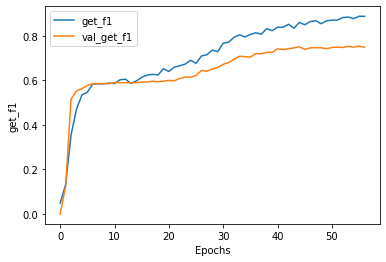

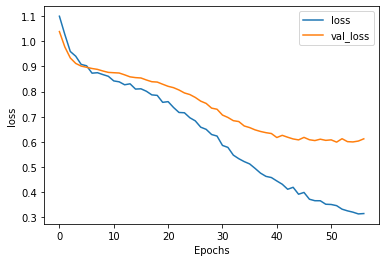

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'get_f1')
plot_graphs(history, 'loss')

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/MA/rnn/rnn_sp.h5")

In [ ]:

a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/rnn/rnn_sp.h5",  custom_objects={"get_f1": get_f1})

In [ ]:
p = model.predict(X_test)

10/10 [==============================] - 0s 2ms/step


In [ ]:
print(classification_report(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1)))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65        96
           1       0.25      0.03      0.06        32
           2       0.79      0.92      0.85       183

    accuracy                           0.74       311
   macro avg       0.57      0.53      0.52       311
weighted avg       0.69      0.74      0.71       311



In [ ]:
print('accuracy')
print(accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1)))
print('f1 score')
print(f1_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))
print('recall')
print(recall_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))
print('precision')
print(precision_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))


accuracy
0.7427652733118971
f1 score
0.70594713245786
recall
0.7427652733118971
precision
0.6928824229076171


### LSTM


In [ ]:
df = train_sp.append(test_sp, ignore_index=True)
df

,id,text,aspectTerm,From,To,SP,text_wo_sw,coc
0,142087,I am very satisfied with it ... I have used th...,price,82,87,positive,satisfied ... device times ... price device .....,satisfied...device times...device...can't expe...
1,142089,"Cheap processing, wobbling unstable unstable l...",processing,6,16,negative,"cheap processing, wobbling unstable unstable l...","cheap, wobbling unstable unstable lids"
2,142089,"Cheap processing, wobbling unstable unstable l...",lids,45,49,negative,"cheap processing, wobbling unstable unstable l...","cheap processing, wobbling unstable unstable f..."
3,142089,"Cheap processing, wobbling unstable unstable l...",baking time,142,153,negative,"cheap processing, wobbling unstable unstable l...",independently time open incredible unreasonabl...
4,142091,"The iron does not remain, the waffles are too ...",waffles,30,37,negative,"iron remain, waffles small waffles brown, six.","iron remain, small waffles brown, six."
...,...,...,...,...,...,...,...,...
1550,145346,It is very simple to handle and the price qual...,coating,81,88,positive,simple handle price quality relationship good....,handle price quality relationship good. non -s...
1551,145357,"Easy to clean, heat enough and the materials s...",clean,8,13,positive,"easy clean, heat materials good quality plasti...","easy, heat materials good quality"
1552,145357,"Easy to clean, heat enough and the materials s...",heat,15,19,positive,"easy clean, heat materials good quality plasti...","easy clean, materials good quality plasticucho..."
1553,145357,"Easy to clean, heat enough and the materials s...",materials,35,44,positive,"easy clean, heat materials good quality plasti...","easy clean, heat good quality plasticuchos. go..."


In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 1000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 10
# This is fixed.
EMBEDDING_DIM =100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['coc'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1765 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['coc'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1555, 10)


In [ ]:
Y = pd.get_dummies(df['SP']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1555, 3)


In [ ]:
Y

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 29)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1244, 10) (1244, 3)
(311, 10) (311, 3)


The first layer is the embedded layer that uses 100 length vectors to represent each word.
SpatialDropout1D performs variational dropout in NLP models.
The next layer is the LSTM layer with 100 memory units.
The output layer must create 3 output values, one for each class.
Activation function is softmax for multi-class classification.
Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.summary()



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 10, 100)           100000    
                                                                 
 spatial_dropout1d_8 (Spatia  (None, 10, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_8 (LSTM)               (None, 100)               80400     
                                                                 
 dense_7 (Dense)             (None, 3)                 303       
                                                                 
Total params: 180,703
Trainable params: 180,703
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = k.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=[get_f1])

In [ ]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/lstm/checkpoint_sp/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 5, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [ ]:
epochs = 100
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=callbacks_list)


Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 1.0887 - get_f1: 0.0000e+00
Epoch 1: val_loss improved from inf to 1.07854, saving model to /content/drive/MyDrive/Colab Notebooks/MA/lstm/checkpoint_sp/
16/16 [==============================] - 8s 335ms/step - loss: 1.0887 - get_f1: 0.0000e+00 - val_loss: 1.0785 - val_get_f1: 0.0000e+00
Epoch 2/100
15/16 [===========================>..] - ETA: 0s - loss: 1.0703 - get_f1: 0.0000e+00
Epoch 2: val_loss improved from 1.07854 to 1.05808, saving model to /content/drive/MyDrive/Colab Notebooks/MA/lstm/checkpoint_sp/
16/16 [==============================] - 4s 274ms/step - loss: 1.0706 - get_f1: 0.0000e+00 - val_loss: 1.0581 - val_get_f1: 0.0000e+00
Epoch 3/100
15/16 [===========================>..] - ETA: 0s - loss: 1.0464 - get_f1: 0.0000e+00
Epoch 3: val_loss improved from 1.05808 to 1.02983, saving model to /content/drive/MyDrive/Colab Notebooks/MA/lstm/checkpoint_sp/
16/16 [==============================] - 4s 267ms/ste

Epoch 42: val_loss did not improve from 0.52517
16/16 [==============================] - 1s 58ms/step - loss: 0.3515 - get_f1: 0.8703 - val_loss: 0.5355 - val_get_f1: 0.7946
Epoch 42: early stopping

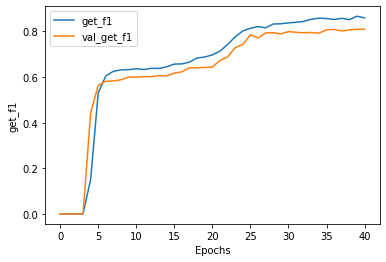

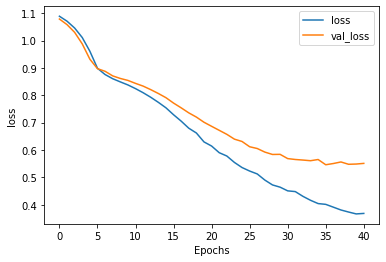

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'get_f1')
plot_graphs(history, 'loss')

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/MA/lstm/lstm_sp.h5")

In [ ]:

a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/lstm/lstm_sp.h5",  custom_objects={"get_f1": get_f1})

In [ ]:
p = model.predict(X_test)

10/10 [==============================] - 0s 4ms/step


In [ ]:
print(classification_report(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1)))

              precision    recall  f1-score   support

           0       0.68      0.76      0.72        96
           1       0.00      0.00      0.00        32
           2       0.81      0.90      0.85       183

    accuracy                           0.77       311
   macro avg       0.50      0.55      0.52       311
weighted avg       0.69      0.77      0.72       311



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy')
print(accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1)))
print('f1 score')
print(f1_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))
print('recall')
print(recall_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))
print('precision')
print(precision_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))


accuracy
0.7652733118971061
f1 score
0.7239763972830023
recall
0.7652733118971061
precision
0.6869219654450833


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Bi-LSTM


In [ ]:
df = train_sp.append(test_sp, ignore_index=True)
df

,id,text,aspectTerm,From,To,SP,text_wo_sw,coc
0,142087,I am very satisfied with it ... I have used th...,price,82,87,positive,satisfied ... device times ... price device .....,satisfied...device times...device...can't expe...
1,142089,"Cheap processing, wobbling unstable unstable l...",processing,6,16,negative,"cheap processing, wobbling unstable unstable l...","cheap, wobbling unstable unstable lids"
2,142089,"Cheap processing, wobbling unstable unstable l...",lids,45,49,negative,"cheap processing, wobbling unstable unstable l...","cheap processing, wobbling unstable unstable f..."
3,142089,"Cheap processing, wobbling unstable unstable l...",baking time,142,153,negative,"cheap processing, wobbling unstable unstable l...",independently time open incredible unreasonabl...
4,142091,"The iron does not remain, the waffles are too ...",waffles,30,37,negative,"iron remain, waffles small waffles brown, six.","iron remain, small waffles brown, six."
...,...,...,...,...,...,...,...,...
1550,145346,It is very simple to handle and the price qual...,coating,81,88,positive,simple handle price quality relationship good....,handle price quality relationship good. non -s...
1551,145357,"Easy to clean, heat enough and the materials s...",clean,8,13,positive,"easy clean, heat materials good quality plasti...","easy, heat materials good quality"
1552,145357,"Easy to clean, heat enough and the materials s...",heat,15,19,positive,"easy clean, heat materials good quality plasti...","easy clean, materials good quality plasticucho..."
1553,145357,"Easy to clean, heat enough and the materials s...",materials,35,44,positive,"easy clean, heat materials good quality plasti...","easy clean, heat good quality plasticuchos. go..."


In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 1000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 10
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['coc'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1765 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['coc'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1555, 10)


In [ ]:
Y = pd.get_dummies(df['SP']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1555, 3)


In [ ]:
Y

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 29)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1244, 10) (1244, 3)
(311, 10) (311, 3)


The first layer is the embedded layer that uses 100 length vectors to represent each word.
SpatialDropout1D performs variational dropout in NLP models.
The next layer is the LSTM layer with 100 memory units.
The output layer must create 3 output values, one for each class.
Activation function is softmax for multi-class classification.
Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(3, activation='softmax'))
model.summary()



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 10, 100)           100000    
                                                                 
 spatial_dropout1d_9 (Spatia  (None, 10, 100)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 3)                 603       
                                                                 
Total params: 261,403
Trainable params: 261,403
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = k.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=[get_f1])

In [ ]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/bilstm/checkpoint_sp/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 5, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [ ]:
epochs = 100
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=callbacks_list)


Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 1.0845 - get_f1: 0.0000e+00
Epoch 1: val_loss improved from inf to 1.06998, saving model to /content/drive/MyDrive/Colab Notebooks/MA/bilstm/checkpoint_sp/
16/16 [==============================] - 16s 751ms/step - loss: 1.0845 - get_f1: 0.0000e+00 - val_loss: 1.0700 - val_get_f1: 0.0000e+00
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 1.0585 - get_f1: 0.0000e+00
Epoch 2: val_loss improved from 1.06998 to 1.04331, saving model to /content/drive/MyDrive/Colab Notebooks/MA/bilstm/checkpoint_sp/
16/16 [==============================] - 11s 718ms/step - loss: 1.0585 - get_f1: 0.0000e+00 - val_loss: 1.0433 - val_get_f1: 0.0000e+00
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 1.0287 - get_f1: 0.0000e+00
Epoch 3: val_loss improved from 1.04331 to 1.01018, saving model to /content/drive/MyDrive/Colab Notebooks/MA/bilstm/checkpoint_sp/
16/16 [==============================] - 10s 

Epoch 26: val_loss did not improve from 0.61862
16/16 [==============================] - 2s 126ms/step - loss: 0.3744 - get_f1: 0.8567 - val_loss: 0.6383 - val_get_f1: 0.7855
Epoch 26: early stopping

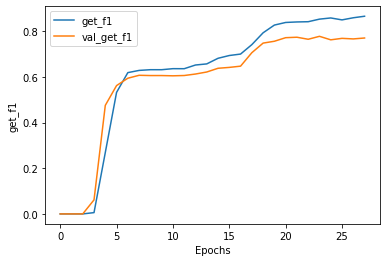

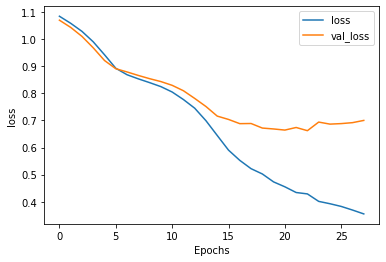

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'get_f1')
plot_graphs(history, 'loss')

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/MA/bilstm/bilstm_sp.h5")

In [ ]:

a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/bilstm/bilstm_sp.h5",  custom_objects={"get_f1": get_f1})

In [ ]:
p = model.predict(X_test)

10/10 [==============================] - 1s 7ms/step


In [ ]:
print(classification_report(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1)))

              precision    recall  f1-score   support

           0       0.66      0.81      0.73        96
           1       0.00      0.00      0.00        32
           2       0.84      0.89      0.86       183

    accuracy                           0.77       311
   macro avg       0.50      0.57      0.53       311
weighted avg       0.70      0.77      0.73       311



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy')
print(accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1)))
print('f1 score')
print(f1_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))
print('recall')
print(recall_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))
print('precision')
print(precision_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))


accuracy
0.7717041800643086
f1 score
0.7323723921334031
recall
0.7717041800643086
precision
0.6988122821475857


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### GRU


In [ ]:
df = train_sp.append(test_sp, ignore_index=True)
df

,id,text,aspectTerm,From,To,SP,text_wo_sw,coc
0,142087,I am very satisfied with it ... I have used th...,price,82,87,positive,satisfied ... device times ... price device .....,satisfied...device times...device...can't expe...
1,142089,"Cheap processing, wobbling unstable unstable l...",processing,6,16,negative,"cheap processing, wobbling unstable unstable l...","cheap, wobbling unstable unstable lids"
2,142089,"Cheap processing, wobbling unstable unstable l...",lids,45,49,negative,"cheap processing, wobbling unstable unstable l...","cheap processing, wobbling unstable unstable f..."
3,142089,"Cheap processing, wobbling unstable unstable l...",baking time,142,153,negative,"cheap processing, wobbling unstable unstable l...",independently time open incredible unreasonabl...
4,142091,"The iron does not remain, the waffles are too ...",waffles,30,37,negative,"iron remain, waffles small waffles brown, six.","iron remain, small waffles brown, six."
...,...,...,...,...,...,...,...,...
1550,145346,It is very simple to handle and the price qual...,coating,81,88,positive,simple handle price quality relationship good....,handle price quality relationship good. non -s...
1551,145357,"Easy to clean, heat enough and the materials s...",clean,8,13,positive,"easy clean, heat materials good quality plasti...","easy, heat materials good quality"
1552,145357,"Easy to clean, heat enough and the materials s...",heat,15,19,positive,"easy clean, heat materials good quality plasti...","easy clean, materials good quality plasticucho..."
1553,145357,"Easy to clean, heat enough and the materials s...",materials,35,44,positive,"easy clean, heat materials good quality plasti...","easy clean, heat good quality plasticuchos. go..."


In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 1000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 10
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['coc'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1765 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['coc'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1555, 10)


In [ ]:
Y = pd.get_dummies(df['SP']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1555, 3)


In [ ]:
Y

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 29)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1244, 10) (1244, 3)
(311, 10) (311, 3)


The first layer is the embedded layer that uses 100 length vectors to represent each word.
SpatialDropout1D performs variational dropout in NLP models.
The next layer is the LSTM layer with 100 memory units.
The output layer must create 3 output values, one for each class.
Activation function is softmax for multi-class classification.
Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.summary()



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 10, 100)           100000    
                                                                 
 spatial_dropout1d_10 (Spati  (None, 10, 100)          0         
 alDropout1D)                                                    
                                                                 
 gru (GRU)                   (None, 100)               60600     
                                                                 
 dense_9 (Dense)             (None, 3)                 303       
                                                                 
Total params: 160,903
Trainable params: 160,903
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = k.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=[get_f1])

In [ ]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/gru/checkpoint_sp/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 5, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [ ]:
epochs = 100
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=callbacks_list)


Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 1.0950 - get_f1: 0.0000e+00
Epoch 1: val_loss improved from inf to 1.08665, saving model to /content/drive/MyDrive/Colab Notebooks/MA/gru/checkpoint_sp/
16/16 [==============================] - 10s 504ms/step - loss: 1.0950 - get_f1: 0.0000e+00 - val_loss: 1.0867 - val_get_f1: 0.0000e+00
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 1.0781 - get_f1: 0.0000e+00
Epoch 2: val_loss improved from 1.08665 to 1.07116, saving model to /content/drive/MyDrive/Colab Notebooks/MA/gru/checkpoint_sp/
16/16 [==============================] - 4s 279ms/step - loss: 1.0781 - get_f1: 0.0000e+00 - val_loss: 1.0712 - val_get_f1: 0.0000e+00
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 1.0604 - get_f1: 0.0000e+00
Epoch 3: val_loss improved from 1.07116 to 1.05286, saving model to /content/drive/MyDrive/Colab Notebooks/MA/gru/checkpoint_sp/
16/16 [==============================] - 5s 329ms/step 

Epoch 26: val_loss did not improve from 0.61862
16/16 [==============================] - 2s 126ms/step - loss: 0.3744 - get_f1: 0.8567 - val_loss: 0.6383 - val_get_f1: 0.7855
Epoch 26: early stopping

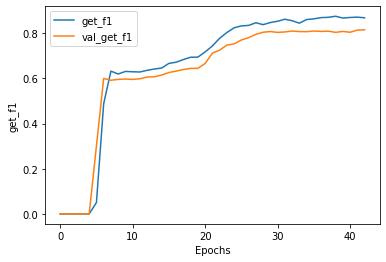

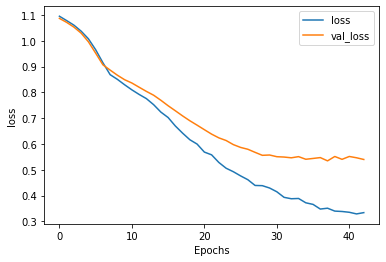

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'get_f1')
plot_graphs(history, 'loss')

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/MA/gru/gru_sp.h5")

In [ ]:

a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/gru/gru_sp.h5",  custom_objects={"get_f1": get_f1})

In [ ]:
p = model.predict(X_test)

10/10 [==============================] - 0s 4ms/step


In [ ]:
print(classification_report(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1)))

              precision    recall  f1-score   support

           0       0.65      0.76      0.70        96
           1       0.00      0.00      0.00        32
           2       0.81      0.89      0.85       183

    accuracy                           0.76       311
   macro avg       0.49      0.55      0.52       311
weighted avg       0.68      0.76      0.72       311



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy')
print(accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1)))
print('f1 score')
print(f1_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))
print('recall')
print(recall_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))
print('precision')
print(precision_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))


accuracy
0.7556270096463023
f1 score
0.7157532960465571
recall
0.7556270096463023
precision
0.6802131927436909


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Bi-GRU


In [ ]:
df = train_sp.append(test_sp, ignore_index=True)
df

,id,text,aspectTerm,From,To,SP,text_wo_sw,coc
0,142087,I am very satisfied with it ... I have used th...,price,82,87,positive,satisfied ... device times ... price device .....,satisfied...device times...device...can't expe...
1,142089,"Cheap processing, wobbling unstable unstable l...",processing,6,16,negative,"cheap processing, wobbling unstable unstable l...","cheap, wobbling unstable unstable lids"
2,142089,"Cheap processing, wobbling unstable unstable l...",lids,45,49,negative,"cheap processing, wobbling unstable unstable l...","cheap processing, wobbling unstable unstable f..."
3,142089,"Cheap processing, wobbling unstable unstable l...",baking time,142,153,negative,"cheap processing, wobbling unstable unstable l...",independently time open incredible unreasonabl...
4,142091,"The iron does not remain, the waffles are too ...",waffles,30,37,negative,"iron remain, waffles small waffles brown, six.","iron remain, small waffles brown, six."
...,...,...,...,...,...,...,...,...
1550,145346,It is very simple to handle and the price qual...,coating,81,88,positive,simple handle price quality relationship good....,handle price quality relationship good. non -s...
1551,145357,"Easy to clean, heat enough and the materials s...",clean,8,13,positive,"easy clean, heat materials good quality plasti...","easy, heat materials good quality"
1552,145357,"Easy to clean, heat enough and the materials s...",heat,15,19,positive,"easy clean, heat materials good quality plasti...","easy clean, materials good quality plasticucho..."
1553,145357,"Easy to clean, heat enough and the materials s...",materials,35,44,positive,"easy clean, heat materials good quality plasti...","easy clean, heat good quality plasticuchos. go..."


In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 1000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 10
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['coc'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1765 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['coc'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1555, 10)


In [ ]:
Y = pd.get_dummies(df['SP']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1555, 3)


In [ ]:
Y

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 29)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1244, 10) (1244, 3)
(311, 10) (311, 3)


The first layer is the embedded layer that uses 100 length vectors to represent each word.
SpatialDropout1D performs variational dropout in NLP models.
The next layer is the LSTM layer with 100 memory units.
The output layer must create 3 output values, one for each class.
Activation function is softmax for multi-class classification.
Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(3, activation='softmax'))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           100000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 10, 100)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 200)              121200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 3)                 603       
                                                                 
Total params: 221,803
Trainable params: 221,803
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = k.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=[get_f1])

In [ ]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/bigru/checkpoint_sp/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 5, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [ ]:
epochs = 100
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=callbacks_list)


Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 1.0892 - get_f1: 0.0000e+00
Epoch 1: val_loss improved from inf to 1.06996, saving model to /content/drive/MyDrive/Colab Notebooks/MA/bigru/checkpoint_sp/
16/16 [==============================] - 21s 976ms/step - loss: 1.0892 - get_f1: 0.0000e+00 - val_loss: 1.0700 - val_get_f1: 0.0000e+00
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 1.0530 - get_f1: 0.0000e+00
Epoch 2: val_loss improved from 1.06996 to 1.03647, saving model to /content/drive/MyDrive/Colab Notebooks/MA/bigru/checkpoint_sp/
16/16 [==============================] - 10s 685ms/step - loss: 1.0530 - get_f1: 0.0000e+00 - val_loss: 1.0365 - val_get_f1: 0.0000e+00
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 1.0177 - get_f1: 0.0000e+00
Epoch 3: val_loss improved from 1.03647 to 1.00175, saving model to /content/drive/MyDrive/Colab Notebooks/MA/bigru/checkpoint_sp/
16/16 [==============================] - 11s 740

Epoch 26: val_loss did not improve from 0.61862
16/16 [==============================] - 2s 126ms/step - loss: 0.3744 - get_f1: 0.8567 - val_loss: 0.6383 - val_get_f1: 0.7855
Epoch 26: early stopping

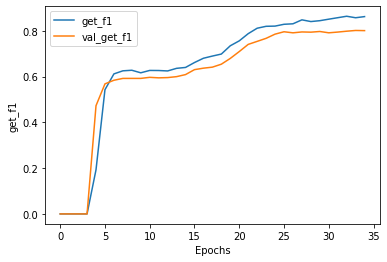

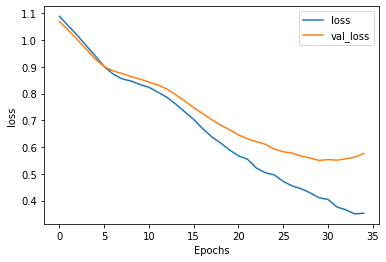

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'get_f1')
plot_graphs(history, 'loss')

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/MA/bigru/bigru_sp.h5")

In [ ]:

a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/bigru/bigru_sp.h5",  custom_objects={"get_f1": get_f1})

In [ ]:
p = model.predict(X_test)

10/10 [==============================] - 1s 8ms/step


In [ ]:
print(classification_report(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1)))

              precision    recall  f1-score   support

           0       0.67      0.77      0.72        96
           1       0.00      0.00      0.00        32
           2       0.82      0.90      0.85       183

    accuracy                           0.77       311
   macro avg       0.50      0.56      0.52       311
weighted avg       0.69      0.77      0.72       311



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy')
print(accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1)))
print('f1 score')
print(f1_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))
print('recall')
print(recall_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))
print('precision')
print(precision_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))


accuracy
0.7652733118971061
f1 score
0.7243838385415041
recall
0.7652733118971061
precision
0.6877660804425693


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Transfomers

### BERT

In [ ]:
MAX_LEN = 10

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
def tokenize(data,max_len = MAX_LEN):
    input_ids = list()
    attention_mask = list()
    for i in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens = True,
                                        max_length = MAX_LEN,
                                        is_split_into_words=True,
                                        return_attention_mask=True,
                                        padding = 'max_length',
                                        truncation=True,return_tensors = 'np')
                        
        
        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
    return np.vstack(input_ids),np.vstack(attention_mask)

In [ ]:
df = train_sp.append(test_sp, ignore_index=True)
df.loc[df['SP'] == 'positive', 'SP'] = 1
df.loc[df['SP'] == 'negative', 'SP'] = -1
df.loc[df['SP'] == 'neutral', 'SP'] = 0

data = df.groupby(["coc","id","aspectTerm","From","To"])["coc"].apply(list).values
labels = df.groupby(["coc","id","aspectTerm","From","To"])["SP"].apply(list).values

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=29)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1088,), (467,), (1088,), (467,))

In [ ]:
input_ids,attention_mask = tokenize(X_train,max_len = MAX_LEN)
val_input_ids,val_attention_mask = tokenize(X_test,max_len = MAX_LEN)

100%|██████████| 467/467 [00:00<00:00, 8129.07it/s]


In [ ]:
test_tag

[array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0]),


In [ ]:
input_ids.shape

(1088, 10)

In [ ]:
# TEST: Checking Padding and Truncation length's
was = list()
for i in range(len(input_ids)):
    was.append(len(input_ids[i]))
set(was)

{10}

In [ ]:
# Train Padding with 2
test_tag = list()
for i in range(len(y_test)):
    test_tag.append(np.array(y_test[i] + [0] * (MAX_LEN-len(y_test[i]))))
    
# TEST:  Checking Padding Length
was = list()
for i in range(len(test_tag)):
    was.append(len(test_tag[i]))
set(was)

{10}

In [ ]:
# Train Padding with 2
train_tag = list()
for i in range(len(y_train)):
    train_tag.append(np.array(y_train[i] + [0] * (MAX_LEN-len(y_train[i]))))
    
# TEST:  Checking Padding Length
was = list()
for i in range(len(train_tag)):
    was.append(len(train_tag[i]))
set(was)

{10}

ON THE RIGHT TRACK, TRY TO FIGURE OUT ONE TAG

In [ ]:
test_tag 

In [ ]:
n_tags = 3
def create_model(bert_model,max_len = MAX_LEN):
    input_ids = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    bert_output = bert_model(input_ids,attention_mask = attention_masks,return_dict =True)
    embedding = tf.keras.layers.Dropout(0.3)(bert_output["last_hidden_state"])
    output = tf.keras.layers.Dense(n_tags,activation = 'softmax')(embedding)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = [output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
model = create_model(bert_model,MAX_LEN)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 tf_bert_model_6 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_13[0][0]',               
                                thPoolingAndCrossAt               'input_14[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 10,                                          

In [ ]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 10, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [ ]:
history_bert = model.fit([input_ids,attention_mask],np.array(train_tag),validation_data = ([val_input_ids,val_attention_mask],np.array(test_tag)),epochs = 50,batch_size = 30,callbacks = callbacks_list,verbose = 1, validation_split=0.1)

Epoch 1/50


37/37 [==============================] - ETA: 0s - loss: nan - accuracy: 0.8913
Epoch 1: val_loss did not improve from inf
37/37 [==============================] - 24s 210ms/step - loss: nan - accuracy: 0.8913 - val_loss: nan - val_accuracy: 0.9071
Epoch 2/50
37/37 [==============================] - ETA: 0s - loss: nan - accuracy: 0.9097
Epoch 2: val_loss did not improve from inf
37/37 [==============================] - 4s 115ms/step - loss: nan - accuracy: 0.9097 - val_loss: nan - val_accuracy: 0.9071
Epoch 3/50
37/37 [==============================] - ETA: 0s - loss: nan - accuracy: 0.9097
Epoch 3: val_loss did not improve from inf
37/37 [==============================] - 4s 116ms/step - loss: nan - accuracy: 0.9097 - val_loss: nan - val_accuracy: 0.9071
Epoch 4/50
37/37 [==============================] - ETA: 0s - loss: nan - accuracy: 0.9097
Epoch 4: val_loss did not improve from inf
37/37 [==============================] - 4s 115ms/step - loss: nan - accuracy: 0.9097 - val_loss: n

In [ ]:
 a.predict([val_input_ids,val_attention_mask])

NameError: ignored

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/MA/bert/bert_sp.h5")

In [ ]:
a = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/bert/bert_ate.h5",  custom_objects={"TFBertModel": TFBertModel})

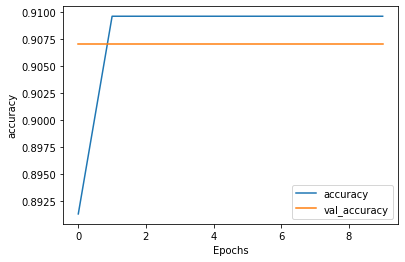

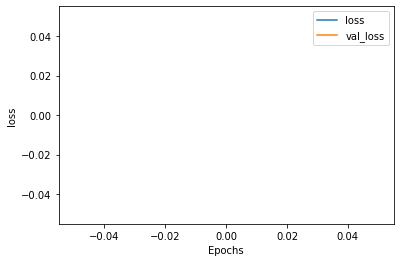

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history_bert, 'accuracy')
plot_graphs(history_bert, 'loss')

In [ ]:
def pred(val_input_ids,val_attention_mask):
    return a.predict([val_input_ids,val_attention_mask])

In [ ]:
def testing(val_input_ids,val_attention_mask,enc_tag,y_test):
    val_input = val_input_ids.reshape(1,maxlen)
    val_attention = val_attention_mask.reshape(1,maxlen)
    
    # Print Original Sentence
    sentence = tokenizer.decode(val_input_ids[val_input_ids > 0])
    #print("Original Text : ",str(sentence))
    #print("\n")
    true_enc_tag = enc_tag.inverse_transform(y_test)

    #print("Original Tags : " ,str(true_enc_tag))
    #print("\n")
    
    pred_with_pad = np.argmax(pred(val_input,val_attention),axis = -1) 
    pred_without_pad = pred_with_pad[pred_with_pad>-1]
    pred_enc_tag = enc_tag.inverse_transform(pred_without_pad)
    pred_final = pred_enc_tag[0:len(true_enc_tag)]
    #print("Predicted Tags : ",pred_enc_tag[0:len(true_enc_tag)])
    return true_enc_tag, pred_final
  

In [ ]:
testing(val_input_ids[2],val_attention_mask[2],enc_tag,y_test[2])

In [ ]:
results = []
for i in range(len(y_test)):
  result = testing(val_input_ids[i],val_attention_mask[i],enc_tag,y_test[i])
  results.append(result)

y_trues = []
for i in range(len(results)):
  y_true = results[i][0]
  y_trues.append(y_true)

y_preds = []
for i in range(len(results)):
  y_pred = results[i][1]
  y_preds.append(y_pred)


In [ ]:
final = pd.DataFrame({"col1": np.concatenate(y_trues, axis=0),"col2": np.concatenate(y_preds, axis=0)})

In [ ]:
print('accuracy')
print(accuracy_score(final.col1, final.col2))
print('f1 score')
print(f1_score(final.col1, final.col2,average=None))
print('recall')
print(recall_score(final.col1, final.col2,average=None))
print('precision')
print(precision_score(final.col1, final.col2,average=None))

In [ ]:
print(classification_report(final.col1, final.col2))

###Bert

In [ ]:

train_sp.loc[train_sp['SP'] == 'positive', 'SP'] = 1
train_sp.loc[train_sp['SP'] == 'negative', 'SP'] = -1
train_sp.loc[train_sp['SP'] == 'neutral', 'SP'] = 0
train = train_sp[['coc','SP']]

test_sp.loc[test_sp['SP'] == 'positive', 'SP'] = 1
test_sp.loc[test_sp['SP'] == 'negative', 'SP'] = -1
test_sp.loc[test_sp['SP'] == 'neutral', 'SP'] = 0
test = test_sp[['coc','SP']]


In [ ]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

In [ ]:
 train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'coc', 
                                                                           'SP')

In [ ]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])
        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )
    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

DATA_COLUMN = 'coc'
LABEL_COLUMN = 'SP'

In [ ]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
train_data

<RepeatDataset element_spec=({'input_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
model = c.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

KeyboardInterrupt: ignored

In [ ]:
model.summary()

In [ ]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001,clipvalue=0.5), 
              loss="sparse_categorical_crossentropy", 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=100, validation_data=validation_data)

### Bert

In [ ]:

#train_sp.loc[train_sp['SP'] == 'positive', 'SP'] = 1
#train_sp.loc[train_sp['SP'] == 'negative', 'SP'] = -1
#train_sp.loc[train_sp['SP'] == 'neutral', 'SP'] = 0
#train = train_sp[['coc','SP']]

df = train_sp#.append(test_sp, ignore_index=True)
df.loc[df['SP'] == 'positive', 'SP'] = 1
df.loc[df['SP'] == 'negative', 'SP'] = -1
df.loc[df['SP'] == 'neutral', 'SP'] = 0
df = df[['coc','SP']]

df = df.astype({'SP':'int'})


In [ ]:
#test data

df_test = test_sp#.append(test_sp, ignore_index=True)
df_test.loc[df_test['SP'] == 'positive', 'SP'] = 1
df_test.loc[df_test['SP'] == 'negative', 'SP'] = -1
df_test.loc[df_test['SP'] == 'neutral', 'SP'] = 0
df_test = df_test[['coc','SP']]

df_test = df_test.astype({'SP':'int'})


In [ ]:
df_test.shape

(467, 2)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

In [ ]:
#test
X_input_ids_test = np.zeros((len(df_test), 256))
X_attn_masks_test = np.zeros((len(df_test), 256))

In [ ]:
def preprocessing_dataset(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['coc'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [ ]:
X_input_ids, X_attn_masks = preprocessing_dataset(df, X_input_ids, X_attn_masks, tokenizer)
#test
X_input_ids_test, X_attn_masks_test = preprocessing_dataset(df_test, X_input_ids_test, X_attn_masks_test, tokenizer)


0it [00:00, ?it/s]
266it [00:00, 2651.75it/s]
545it [00:00, 2732.56it/s]
819it [00:00, 2388.97it/s]
1088it [00:00, 2371.69it/s]

0it [00:00, ?it/s]
467it [00:00, 2796.11it/s]


In [ ]:
labels = np.zeros((len(df), 3))
labels.shape

(1088, 3)

In [ ]:
labels_test = np.zeros((len(df_test), 3))
labels_test.shape

(467, 3)

In [ ]:
labels = pd.get_dummies(df['SP']).values
print('Shape of label tensor:', labels.shape)

Shape of label tensor: (1088, 3)


In [ ]:
labels_test = pd.get_dummies(df_test['SP']).values
print('Shape of label tensor:', labels_test.shape)

Shape of label tensor: (467, 3)


In [ ]:
labels_test

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [ ]:
labels = pd.get_dummies(df['SP']).values
print('Shape of label tensor:', labels.shape)

Shape of label tensor: (1088, 3)


In [ ]:

dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
dataset_test = tf.data.Dataset.from_tensor_slices((X_input_ids_test, X_attn_masks_test, labels_test))
dataset_test.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
len(dataset)

1088

In [ ]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [ ]:
dataset = dataset.map(SentimentDatasetMapFunction) 

In [ ]:
#test
dataset_test = dataset_test.map(SentimentDatasetMapFunction) 

In [ ]:
len(dataset_test)

467

In [ ]:
dataset_test

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
dataset_test.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
dataset = dataset.shuffle(10000).batch(1, drop_remainder=True)
#test
dataset_test = dataset_test.shuffle(10000).batch(1, drop_remainder=True)

In [ ]:
len(dataset_test)

467

In [ ]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(1, 3), dtype=tf.uint8, name=None))>

In [ ]:
dataset_test.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(1, 3), dtype=tf.uint8, name=None))>

In [ ]:
p = np.round_(0.8 * len(dataset))
p
#train_size = int((len(df)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

870.0

In [ ]:
#int((len(df)//16)*p)

In [ ]:
training_dataset = dataset.take(p)
validation_dataset = dataset.skip(p)
#training_dataset = dataset.take(len(dataset))

In [ ]:
len(training_dataset)

870

In [ ]:
len(validation_dataset)

218

In [ ]:
training_dataset

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(1, 3), dtype=tf.uint8, name=None))>

In [ ]:
#test
testing_dataset = dataset_test.take(len(dataset_test))


In [ ]:
len(testing_dataset)

467

In [ ]:
model = TFBertModel.from_pretrained('bert-base-cased') 

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] 

#intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)

embedding = tf.keras.layers.Dropout(0.3)(bert_embds) ##
output_layer = tf.keras.layers.Dense(3, activation='softmax', name='output_layer')(embedding)


sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)


sentiment_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                        

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.000001) #0.000005 try w other learning rate
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 3, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [ ]:


sentiment_model.compile(optimizer=optim, loss="categorical_crossentropy", metrics=[acc],)

In [ ]:
epochs = 100
batch_size = 64

history = sentiment_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    batch_size = batch_size,
    epochs=100,
    callbacks = callbacks_list
)

Epoch 1/100
870/870 [==============================] - ETA: 0s - loss: 1.0592 - accuracy: 0.5115
Epoch 1: val_loss improved from inf to 0.80614, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 119s 124ms/step - loss: 1.0592 - accuracy: 0.5115 - val_loss: 0.8061 - val_accuracy: 0.6101
Epoch 2/100
870/870 [==============================] - ETA: 0s - loss: 0.9256 - accuracy: 0.5632
Epoch 2: val_loss improved from 0.80614 to 0.65958, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 105s 121ms/step - loss: 0.9256 - accuracy: 0.5632 - val_loss: 0.6596 - val_accuracy: 0.7339
Epoch 3/100
870/870 [==============================] - ETA: 0s - loss: 0.7150 - accuracy: 0.7046
Epoch 3: val_loss did not improve from 0.65958
870/870 [==============================] - 72s 83ms/step - loss: 0.7150 - accuracy: 0.7046 - val_loss: 0.7084 - val_accuracy: 0.7064
Epoch 4/100
870/870 [==============================] - ETA: 0s - loss: 0.6428 - accuracy: 0.7529
Epoch 4: val_loss improved from 0.65958 to 0.45257, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 105s 120ms/step - loss: 0.6428 - accuracy: 0.7529 - val_loss: 0.4526 - val_accuracy: 0.8028
Epoch 5/100
870/870 [==============================] - ETA: 0s - loss: 0.5709 - accuracy: 0.7828
Epoch 5: val_loss did not improve from 0.45257
870/870 [==============================] - 73s 84ms/step - loss: 0.5709 - accuracy: 0.7828 - val_loss: 0.4872 - val_accuracy: 0.8073
Epoch 6/100
870/870 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.8080
Epoch 6: val_loss improved from 0.45257 to 0.26468, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 104s 119ms/step - loss: 0.4871 - accuracy: 0.8080 - val_loss: 0.2647 - val_accuracy: 0.9220
Epoch 7/100
870/870 [==============================] - ETA: 0s - loss: 0.4310 - accuracy: 0.8437
Epoch 7: val_loss did not improve from 0.26468
870/870 [==============================] - 73s 84ms/step - loss: 0.4310 - accuracy: 0.8437 - val_loss: 0.2843 - val_accuracy: 0.9037
Epoch 8/100
870/870 [==============================] - ETA: 0s - loss: 0.3880 - accuracy: 0.8517
Epoch 8: val_loss improved from 0.26468 to 0.24932, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 106s 122ms/step - loss: 0.3880 - accuracy: 0.8517 - val_loss: 0.2493 - val_accuracy: 0.8945
Epoch 9/100
870/870 [==============================] - ETA: 0s - loss: 0.3578 - accuracy: 0.8713
Epoch 9: val_loss improved from 0.24932 to 0.24621, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 104s 120ms/step - loss: 0.3578 - accuracy: 0.8713 - val_loss: 0.2462 - val_accuracy: 0.9174
Epoch 10/100
870/870 [==============================] - ETA: 0s - loss: 0.3111 - accuracy: 0.8908
Epoch 10: val_loss improved from 0.24621 to 0.17989, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 105s 121ms/step - loss: 0.3111 - accuracy: 0.8908 - val_loss: 0.1799 - val_accuracy: 0.9312
Epoch 11/100
870/870 [==============================] - ETA: 0s - loss: 0.2674 - accuracy: 0.8920
Epoch 11: val_loss improved from 0.17989 to 0.16665, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 104s 120ms/step - loss: 0.2674 - accuracy: 0.8920 - val_loss: 0.1667 - val_accuracy: 0.9450
Epoch 12/100
870/870 [==============================] - ETA: 0s - loss: 0.2257 - accuracy: 0.9184
Epoch 12: val_loss improved from 0.16665 to 0.09622, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 105s 121ms/step - loss: 0.2257 - accuracy: 0.9184 - val_loss: 0.0962 - val_accuracy: 0.9725
Epoch 13/100
870/870 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.9195
Epoch 13: val_loss did not improve from 0.09622
870/870 [==============================] - 73s 84ms/step - loss: 0.2293 - accuracy: 0.9195 - val_loss: 0.1152 - val_accuracy: 0.9633
Epoch 14/100
870/870 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.9287
Epoch 14: val_loss improved from 0.09622 to 0.05126, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 103s 119ms/step - loss: 0.2069 - accuracy: 0.9287 - val_loss: 0.0513 - val_accuracy: 0.9862
Epoch 15/100
870/870 [==============================] - ETA: 0s - loss: 0.1788 - accuracy: 0.9437
Epoch 15: val_loss did not improve from 0.05126
870/870 [==============================] - 73s 83ms/step - loss: 0.1788 - accuracy: 0.9437 - val_loss: 0.0592 - val_accuracy: 0.9862
Epoch 16/100
870/870 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.9644
Epoch 16: val_loss did not improve from 0.05126
870/870 [==============================] - 72s 83ms/step - loss: 0.1435 - accuracy: 0.9644 - val_loss: 0.0889 - val_accuracy: 0.9862
Epoch 17/100
870/870 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9563Restoring model weights from the end of the best epoch: 14.

Epoch 17: val_loss did not improve from 0.05126
870/870 [==============================] - 72s 83ms/step - loss: 0.1675 - accuracy: 0.9563 - val_loss

In [ ]:
sentiment_model.save("/content/drive/MyDrive/Colab Notebooks/MA/bert/bert_sp.h5")

In [ ]:
#a = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/bert/bert_sp.h5",  custom_objects={"TFBertModel": TFBertModel})

In [ ]:
 a =sentiment_model.predict(testing_dataset)

467/467 [==============================] - 10s 19ms/step


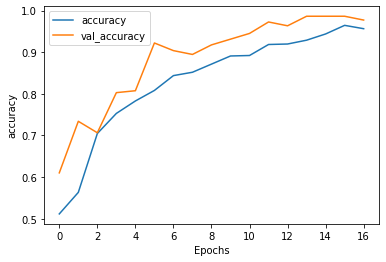

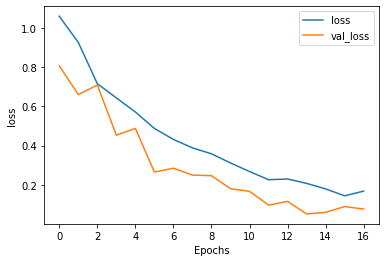

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
arg = np.argmax(a,axis=1)

In [ ]:
y_true = df_test.SP.values

new_y_true = []

for y in y_true:
    new_y_true.append(y+1)

print(new_y_true)

[2, 0, 0, 1, 1, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 1, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 0, 1, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 

In [ ]:
df_test

,coc,SP
0,succeed straight away. gladly again.,1
1,"evenly browned, unfortunately regulation tempe...",-1
2,"great use, ok small use.",-1
3,unfortunately regulation temperature. terms gr...,0
4,unfortunately regulation temperature. terms gr...,0
...,...,...
462,handle price quality relationship good. non -s...,1
463,"easy, heat materials good quality",1
464,"easy clean, materials good quality plasticucho...",1
465,"easy clean, heat good quality plasticuchos. go...",1


In [ ]:
print(classification_report(new_y_true, arg))

              precision    recall  f1-score   support

           0       0.30      0.28      0.29       130
           1       0.00      0.00      0.00        35
           2       0.67      0.70      0.68       302

    accuracy                           0.53       467
   macro avg       0.32      0.33      0.32       467
weighted avg       0.51      0.53      0.52       467



In [ ]:
             precision    recall  f1-score   support

           0       0.30      0.28      0.29       130
           1       0.00      0.00      0.00        35
           2       0.67      0.70      0.68       302

    accuracy                           0.53       467
   macro avg       0.32      0.33      0.32       467
weighted avg       0.51      0.53      0.52       467
lr 0.000001


IndentationError: ignored

### Bert 2 - 0.53 acc --> worst

In [ ]:

#train_sp.loc[train_sp['SP'] == 'positive', 'SP'] = 1
#train_sp.loc[train_sp['SP'] == 'negative', 'SP'] = -1
#train_sp.loc[train_sp['SP'] == 'neutral', 'SP'] = 0
#train = train_sp[['coc','SP']]

df = train_sp#.append(test_sp, ignore_index=True)
df.loc[df['SP'] == 'positive', 'SP'] = 1
df.loc[df['SP'] == 'negative', 'SP'] = -1
df.loc[df['SP'] == 'neutral', 'SP'] = 0
df = df[['coc','SP']]

df = df.astype({'SP':'int'})


In [ ]:
#test data

df_test = test_sp#.append(test_sp, ignore_index=True)
df_test.loc[df_test['SP'] == 'positive', 'SP'] = 1
df_test.loc[df_test['SP'] == 'negative', 'SP'] = -1
df_test.loc[df_test['SP'] == 'neutral', 'SP'] = 0
df_test = df_test[['coc','SP']]

df_test = df_test.astype({'SP':'int'})


In [ ]:
df_test.shape

(467, 2)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

In [ ]:
#test
X_input_ids_test = np.zeros((len(df_test), 256))
X_attn_masks_test = np.zeros((len(df_test), 256))

In [ ]:
def preprocessing_dataset(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['coc'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [ ]:
X_input_ids, X_attn_masks = preprocessing_dataset(df, X_input_ids, X_attn_masks, tokenizer)
#test
X_input_ids_test, X_attn_masks_test = preprocessing_dataset(df_test, X_input_ids_test, X_attn_masks_test, tokenizer)


0it [00:00, ?it/s]
266it [00:00, 2651.75it/s]
545it [00:00, 2732.56it/s]
819it [00:00, 2388.97it/s]
1088it [00:00, 2371.69it/s]

0it [00:00, ?it/s]
467it [00:00, 2796.11it/s]


In [ ]:
labels = np.zeros((len(df), 3))
labels.shape

(1088, 3)

In [ ]:
labels_test = np.zeros((len(df_test), 3))
labels_test.shape

(467, 3)

In [ ]:
labels = pd.get_dummies(df['SP']).values
print('Shape of label tensor:', labels.shape)

Shape of label tensor: (1088, 3)


In [ ]:
labels_test = pd.get_dummies(df_test['SP']).values
print('Shape of label tensor:', labels_test.shape)

Shape of label tensor: (467, 3)


In [ ]:
labels_test

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [ ]:
labels = pd.get_dummies(df['SP']).values
print('Shape of label tensor:', labels.shape)

Shape of label tensor: (1088, 3)


In [ ]:

dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
dataset_test = tf.data.Dataset.from_tensor_slices((X_input_ids_test, X_attn_masks_test, labels_test))
dataset_test.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
len(dataset)

1088

In [ ]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [ ]:
dataset = dataset.map(SentimentDatasetMapFunction) 

In [ ]:
#test
dataset_test = dataset_test.map(SentimentDatasetMapFunction) 

In [ ]:
len(dataset_test)

467

In [ ]:
dataset_test

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
dataset_test.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
dataset = dataset.shuffle(10000).batch(1, drop_remainder=True)
#test
dataset_test = dataset_test.shuffle(10000).batch(1, drop_remainder=True)

In [ ]:
len(dataset_test)

467

In [ ]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(1, 3), dtype=tf.uint8, name=None))>

In [ ]:
dataset_test.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(1, 3), dtype=tf.uint8, name=None))>

In [ ]:
p = np.round_(0.8 * len(dataset))
p
#train_size = int((len(df)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

870.0

In [ ]:
#int((len(df)//16)*p)

In [ ]:
training_dataset = dataset.take(p)
validation_dataset = dataset.skip(p)
#training_dataset = dataset.take(len(dataset))

In [ ]:
len(training_dataset)

870

In [ ]:
len(validation_dataset)

218

In [ ]:
training_dataset

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(1, 3), dtype=tf.uint8, name=None))>

In [ ]:
#test
testing_dataset = dataset_test.take(len(dataset_test))


In [ ]:
len(testing_dataset)

467

In [ ]:
model = TFBertModel.from_pretrained('bert-base-cased') 

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] 

#intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)

embedding = tf.keras.layers.Dropout(0.3)(bert_embds) ##
output_layer = tf.keras.layers.Dense(3, activation='softmax', name='output_layer')(embedding)


sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)


sentiment_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                        

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.000001) #0.000005 try w other learning rate
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 3, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [ ]:


sentiment_model.compile(optimizer=optim, loss="categorical_crossentropy", metrics=[acc],)

In [ ]:
epochs = 100
batch_size = 64

history = sentiment_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    batch_size = batch_size,
    epochs=100,
    callbacks = callbacks_list
)

Epoch 1/100
870/870 [==============================] - ETA: 0s - loss: 1.0592 - accuracy: 0.5115
Epoch 1: val_loss improved from inf to 0.80614, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 119s 124ms/step - loss: 1.0592 - accuracy: 0.5115 - val_loss: 0.8061 - val_accuracy: 0.6101
Epoch 2/100
870/870 [==============================] - ETA: 0s - loss: 0.9256 - accuracy: 0.5632
Epoch 2: val_loss improved from 0.80614 to 0.65958, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 105s 121ms/step - loss: 0.9256 - accuracy: 0.5632 - val_loss: 0.6596 - val_accuracy: 0.7339
Epoch 3/100
870/870 [==============================] - ETA: 0s - loss: 0.7150 - accuracy: 0.7046
Epoch 3: val_loss did not improve from 0.65958
870/870 [==============================] - 72s 83ms/step - loss: 0.7150 - accuracy: 0.7046 - val_loss: 0.7084 - val_accuracy: 0.7064
Epoch 4/100
870/870 [==============================] - ETA: 0s - loss: 0.6428 - accuracy: 0.7529
Epoch 4: val_loss improved from 0.65958 to 0.45257, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 105s 120ms/step - loss: 0.6428 - accuracy: 0.7529 - val_loss: 0.4526 - val_accuracy: 0.8028
Epoch 5/100
870/870 [==============================] - ETA: 0s - loss: 0.5709 - accuracy: 0.7828
Epoch 5: val_loss did not improve from 0.45257
870/870 [==============================] - 73s 84ms/step - loss: 0.5709 - accuracy: 0.7828 - val_loss: 0.4872 - val_accuracy: 0.8073
Epoch 6/100
870/870 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.8080
Epoch 6: val_loss improved from 0.45257 to 0.26468, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 104s 119ms/step - loss: 0.4871 - accuracy: 0.8080 - val_loss: 0.2647 - val_accuracy: 0.9220
Epoch 7/100
870/870 [==============================] - ETA: 0s - loss: 0.4310 - accuracy: 0.8437
Epoch 7: val_loss did not improve from 0.26468
870/870 [==============================] - 73s 84ms/step - loss: 0.4310 - accuracy: 0.8437 - val_loss: 0.2843 - val_accuracy: 0.9037
Epoch 8/100
870/870 [==============================] - ETA: 0s - loss: 0.3880 - accuracy: 0.8517
Epoch 8: val_loss improved from 0.26468 to 0.24932, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 106s 122ms/step - loss: 0.3880 - accuracy: 0.8517 - val_loss: 0.2493 - val_accuracy: 0.8945
Epoch 9/100
870/870 [==============================] - ETA: 0s - loss: 0.3578 - accuracy: 0.8713
Epoch 9: val_loss improved from 0.24932 to 0.24621, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 104s 120ms/step - loss: 0.3578 - accuracy: 0.8713 - val_loss: 0.2462 - val_accuracy: 0.9174
Epoch 10/100
870/870 [==============================] - ETA: 0s - loss: 0.3111 - accuracy: 0.8908
Epoch 10: val_loss improved from 0.24621 to 0.17989, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 105s 121ms/step - loss: 0.3111 - accuracy: 0.8908 - val_loss: 0.1799 - val_accuracy: 0.9312
Epoch 11/100
870/870 [==============================] - ETA: 0s - loss: 0.2674 - accuracy: 0.8920
Epoch 11: val_loss improved from 0.17989 to 0.16665, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 104s 120ms/step - loss: 0.2674 - accuracy: 0.8920 - val_loss: 0.1667 - val_accuracy: 0.9450
Epoch 12/100
870/870 [==============================] - ETA: 0s - loss: 0.2257 - accuracy: 0.9184
Epoch 12: val_loss improved from 0.16665 to 0.09622, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 105s 121ms/step - loss: 0.2257 - accuracy: 0.9184 - val_loss: 0.0962 - val_accuracy: 0.9725
Epoch 13/100
870/870 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.9195
Epoch 13: val_loss did not improve from 0.09622
870/870 [==============================] - 73s 84ms/step - loss: 0.2293 - accuracy: 0.9195 - val_loss: 0.1152 - val_accuracy: 0.9633
Epoch 14/100
870/870 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.9287
Epoch 14: val_loss improved from 0.09622 to 0.05126, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 103s 119ms/step - loss: 0.2069 - accuracy: 0.9287 - val_loss: 0.0513 - val_accuracy: 0.9862
Epoch 15/100
870/870 [==============================] - ETA: 0s - loss: 0.1788 - accuracy: 0.9437
Epoch 15: val_loss did not improve from 0.05126
870/870 [==============================] - 73s 83ms/step - loss: 0.1788 - accuracy: 0.9437 - val_loss: 0.0592 - val_accuracy: 0.9862
Epoch 16/100
870/870 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.9644
Epoch 16: val_loss did not improve from 0.05126
870/870 [==============================] - 72s 83ms/step - loss: 0.1435 - accuracy: 0.9644 - val_loss: 0.0889 - val_accuracy: 0.9862
Epoch 17/100
870/870 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9563Restoring model weights from the end of the best epoch: 14.

Epoch 17: val_loss did not improve from 0.05126
870/870 [==============================] - 72s 83ms/step - loss: 0.1675 - accuracy: 0.9563 - val_loss

In [ ]:
sentiment_model.save("/content/drive/MyDrive/Colab Notebooks/MA/bert/bert_sp.h5")

In [ ]:
#a = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/bert/bert_sp.h5",  custom_objects={"TFBertModel": TFBertModel})

In [ ]:
 a =sentiment_model.predict(testing_dataset)

467/467 [==============================] - 10s 19ms/step


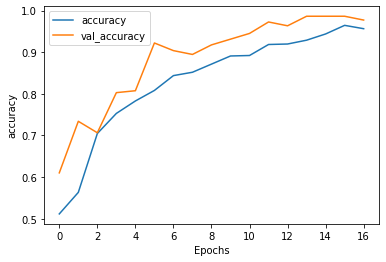

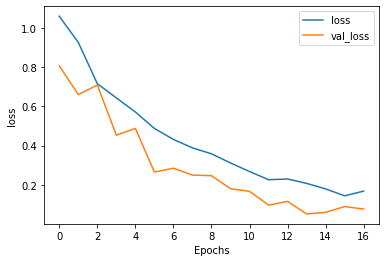

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
arg = np.argmax(a,axis=1)

In [ ]:
y_true = df_test.SP.values

new_y_true = []

for y in y_true:
    new_y_true.append(y+1)

print(new_y_true)

[2, 0, 0, 1, 1, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 1, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 0, 1, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 

In [ ]:
df_test

,coc,SP
0,succeed straight away. gladly again.,1
1,"evenly browned, unfortunately regulation tempe...",-1
2,"great use, ok small use.",-1
3,unfortunately regulation temperature. terms gr...,0
4,unfortunately regulation temperature. terms gr...,0
...,...,...
462,handle price quality relationship good. non -s...,1
463,"easy, heat materials good quality",1
464,"easy clean, materials good quality plasticucho...",1
465,"easy clean, heat good quality plasticuchos. go...",1


In [ ]:
print(classification_report(new_y_true, arg))

              precision    recall  f1-score   support

           0       0.30      0.28      0.29       130
           1       0.00      0.00      0.00        35
           2       0.67      0.70      0.68       302

    accuracy                           0.53       467
   macro avg       0.32      0.33      0.32       467
weighted avg       0.51      0.53      0.52       467



In [ ]:
             precision    recall  f1-score   support

           0       0.30      0.28      0.29       130
           1       0.00      0.00      0.00        35
           2       0.67      0.70      0.68       302

    accuracy                           0.53       467
   macro avg       0.32      0.33      0.32       467
weighted avg       0.51      0.53      0.52       467
lr 0.000001


IndentationError: ignored

### Bert 2 - 0.64 acc

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [ ]:
df_dl = pd.concat([train_sp,test_sp])
df_dl = df_dl[['coc','SP']]

In [ ]:


df_dl.loc[df_dl['SP'] == 'positive', 'SP'] = 1
df_dl.loc[df_dl['SP'] == 'negative', 'SP'] = -1
df_dl.loc[df_dl['SP'] == 'neutral', 'SP'] = 0
df_dl = df_dl[['coc','SP']]

df_dl = df_dl.astype({'SP':'int'})


In [ ]:
df_dl

,coc,SP
0,satisfied...device times...device...can't expe...,1
1,"cheap, wobbling unstable unstable lids",-1
2,"cheap processing, wobbling unstable unstable f...",-1
3,independently time open incredible unreasonabl...,-1
4,"iron remain, small waffles brown, six.",-1
...,...,...
462,handle price quality relationship good. non -s...,1
463,"easy, heat materials good quality",1
464,"easy clean, materials good quality plasticucho...",1
465,"easy clean, heat good quality plasticuchos. go...",1


In [ ]:
df_dl.shape

(1555, 2)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df_dl.coc,df_dl.SP,random_state=29,test_size=0.3)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1088,), (467,), (1088,), (467,))

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
X_input_ids = np.zeros((len(X_train), 256))
X_attn_masks = np.zeros((len(X_train), 256))

In [ ]:
def preprocessing_dataset(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df)):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [ ]:
X_input_ids, X_attn_masks = preprocessing_dataset(X_train, X_input_ids, X_attn_masks, tokenizer)
#test
X_input_ids_test, X_attn_masks_test = preprocessing_dataset(X_test, X_input_ids_test, X_attn_masks_test, tokenizer)

1088it [00:00, 2782.71it/s]
467it [00:00, 2782.67it/s]


In [ ]:
labels = np.zeros((len(X_train), 3))
labels.shape

(1088, 3)

In [ ]:
labels_test = np.zeros((len(X_test), 3))
labels_test.shape

(467, 3)

In [ ]:
labels = pd.get_dummies(y_train).values
print('Shape of label tensor:', labels.shape)

Shape of label tensor: (1088, 3)


In [ ]:
labels_test = pd.get_dummies(y_test).values
print('Shape of label tensor:', labels_test.shape)

Shape of label tensor: (467, 3)


In [ ]:
labels_test

array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]], dtype=uint8)

In [ ]:
labels = pd.get_dummies(df['SP']).values
print('Shape of label tensor:', labels.shape)

Shape of label tensor: (1088, 3)


In [ ]:

dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
len(X_input_ids)

1088

In [ ]:
dataset_test = tf.data.Dataset.from_tensor_slices((X_input_ids_test, X_attn_masks_test, labels_test))
dataset_test.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
len(dataset)

1088

In [ ]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [ ]:
dataset = dataset.map(SentimentDatasetMapFunction) 

In [ ]:
#test
dataset_test = dataset_test.map(SentimentDatasetMapFunction) 

In [ ]:
len(dataset_test)

467

In [ ]:
dataset_test

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
dataset_test.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
dataset = dataset.shuffle(10000).batch(1, drop_remainder=True)
#test
dataset_test = dataset_test.shuffle(10000).batch(1, drop_remainder=True)

In [ ]:
len(dataset_test)

467

In [ ]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(1, 3), dtype=tf.uint8, name=None))>

In [ ]:
dataset_test.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(1, 3), dtype=tf.uint8, name=None))>

In [ ]:
p = np.round_(0.8 * len(dataset))
p
#train_size = int((len(df)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

870.0

In [ ]:
#int((len(df)//16)*p)

In [ ]:
training_dataset = dataset.take(p)
validation_dataset = dataset.skip(p)
#training_dataset = dataset.take(len(dataset))

In [ ]:
len(training_dataset)

870

In [ ]:
len(validation_dataset)

218

In [ ]:
training_dataset

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(1, 3), dtype=tf.uint8, name=None))>

In [ ]:
#test
testing_dataset = dataset_test.take(len(dataset_test))


In [ ]:
len(testing_dataset)

467

In [ ]:
model = TFBertModel.from_pretrained('bert-base-cased') 

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] 

#intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)

embedding = tf.keras.layers.Dropout(0.3)(bert_embds) ##
output_layer = tf.keras.layers.Dense(3, activation='softmax', name='output_layer')(embedding)


sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)


sentiment_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                        

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.000001) #0.000005 try w other learning rate
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 3, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [ ]:


sentiment_model.compile(optimizer=optim, loss="categorical_crossentropy", metrics=[acc],)

In [ ]:
epochs = 100
batch_size = 64

history = sentiment_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    batch_size = batch_size,
    epochs=100,
    callbacks = callbacks_list
)

Epoch 1/100
870/870 [==============================] - ETA: 0s - loss: 1.2109 - accuracy: 0.4253
Epoch 1: val_loss improved from inf to 0.86516, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 119s 124ms/step - loss: 1.2109 - accuracy: 0.4253 - val_loss: 0.8652 - val_accuracy: 0.6101
Epoch 2/100
870/870 [==============================] - ETA: 0s - loss: 1.0428 - accuracy: 0.5126
Epoch 2: val_loss improved from 0.86516 to 0.81358, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 106s 122ms/step - loss: 1.0428 - accuracy: 0.5126 - val_loss: 0.8136 - val_accuracy: 0.6422
Epoch 3/100
870/870 [==============================] - ETA: 0s - loss: 0.9333 - accuracy: 0.5621
Epoch 3: val_loss did not improve from 0.81358
870/870 [==============================] - 73s 84ms/step - loss: 0.9333 - accuracy: 0.5621 - val_loss: 0.8515 - val_accuracy: 0.5917
Epoch 4/100
870/870 [==============================] - ETA: 0s - loss: 0.9134 - accuracy: 0.5851
Epoch 4: val_loss did not improve from 0.81358
870/870 [==============================] - 72s 83ms/step - loss: 0.9134 - accuracy: 0.5851 - val_loss: 0.8204 - val_accuracy: 0.6147
Epoch 5/100
870/870 [==============================] - ETA: 0s - loss: 0.8944 - accuracy: 0.5805Restoring model weights from the end of the best epoch: 2.

Epoch 5: val_loss did not improve from 0.81358
870/870 [==============================] - 73s 84ms/step - loss: 0.8944 - accuracy: 0.5805 - val_loss: 0.830

In [ ]:
sentiment_model.save("/content/drive/MyDrive/Colab Notebooks/MA/bert/bert_sp.h5")

In [ ]:
#a = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/bert/bert_sp.h5",  custom_objects={"TFBertModel": TFBertModel})

In [ ]:
 a =sentiment_model.predict(testing_dataset)

467/467 [==============================] - 10s 19ms/step


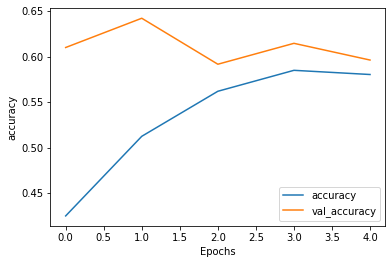

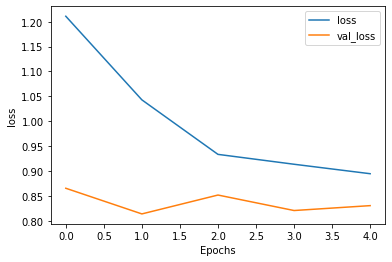

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
arg = np.argmax(a,axis=1)

In [ ]:
y_true = df_test.SP.values

new_y_true = []

for y in y_true:
    new_y_true.append(y+1)

print(new_y_true)

[2, 0, 0, 1, 1, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 1, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 0, 1, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 

In [ ]:
df_test

,coc,SP
0,succeed straight away. gladly again.,1
1,"evenly browned, unfortunately regulation tempe...",-1
2,"great use, ok small use.",-1
3,unfortunately regulation temperature. terms gr...,0
4,unfortunately regulation temperature. terms gr...,0
...,...,...
462,handle price quality relationship good. non -s...,1
463,"easy, heat materials good quality",1
464,"easy clean, materials good quality plasticucho...",1
465,"easy clean, heat good quality plasticuchos. go...",1


In [ ]:
print(classification_report(new_y_true, arg))

              precision    recall  f1-score   support

           0       0.33      0.01      0.02       130
           1       0.00      0.00      0.00        35
           2       0.65      0.99      0.78       302

    accuracy                           0.64       467
   macro avg       0.33      0.33      0.27       467
weighted avg       0.51      0.64      0.51       467



In [ ]:
          precision    recall  f1-score   support

           0       0.33      0.01      0.02       130
           1       0.00      0.00      0.00        35
           2       0.65      0.99      0.78       302

    accuracy                           0.64       467
   macro avg       0.33      0.33      0.27       467
weighted avg       0.51      0.64      0.51       467

IndentationError: ignored

### Bert 2

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [ ]:
df_dl = pd.concat([train_sp,test_sp])
df_dl = df_dl[['coc','SP']]

In [ ]:


df_dl.loc[df_dl['SP'] == 'positive', 'SP'] = 1
df_dl.loc[df_dl['SP'] == 'negative', 'SP'] = -1
df_dl.loc[df_dl['SP'] == 'neutral', 'SP'] = 0
df_dl = df_dl[['coc','SP']]

df_dl = df_dl.astype({'SP':'int'})


In [ ]:
df_dl

,coc,SP
0,satisfied...device times...device...can't expe...,1
1,"cheap, wobbling unstable unstable lids",-1
2,"cheap processing, wobbling unstable unstable f...",-1
3,independently time open incredible unreasonabl...,-1
4,"iron remain, small waffles brown, six.",-1
...,...,...
462,handle price quality relationship good. non -s...,1
463,"easy, heat materials good quality",1
464,"easy clean, materials good quality plasticucho...",1
465,"easy clean, heat good quality plasticuchos. go...",1


In [ ]:
df_dl.shape

(1555, 2)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df_dl.coc,df_dl.SP,random_state=29,test_size=0.3)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1088,), (467,), (1088,), (467,))

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
X_input_ids = np.zeros((len(X_train), 256))
X_attn_masks = np.zeros((len(X_train), 256))

In [ ]:
X_input_ids_test = np.zeros((len(X_test), 256))
X_attn_masks_test = np.zeros((len(X_test), 256))

In [ ]:
def preprocessing_dataset(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df)):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [ ]:
X_input_ids, X_attn_masks = preprocessing_dataset(X_train, X_input_ids, X_attn_masks, tokenizer)
#test
X_input_ids_test, X_attn_masks_test = preprocessing_dataset(X_test, X_input_ids_test, X_attn_masks_test, tokenizer)

1088it [00:00, 2662.32it/s]
467it [00:00, 2779.04it/s]


In [ ]:
labels = np.zeros((len(X_train), 3))
labels.shape

(1088, 3)

In [ ]:
labels_test = np.zeros((len(X_test), 3))
labels_test.shape

(467, 3)

In [ ]:
labels = pd.get_dummies(y_train).values
print('Shape of label tensor:', labels.shape)

Shape of label tensor: (1088, 3)


In [ ]:
labels_test = pd.get_dummies(y_test).values
print('Shape of label tensor:', labels_test.shape)

Shape of label tensor: (467, 3)


In [ ]:
labels_test

array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]], dtype=uint8)

In [ ]:

dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
len(X_input_ids)

1088

In [ ]:
dataset_test = tf.data.Dataset.from_tensor_slices((X_input_ids_test, X_attn_masks_test, labels_test))
dataset_test.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
len(dataset)

1088

In [ ]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [ ]:
dataset = dataset.map(SentimentDatasetMapFunction) 

In [ ]:
#test
dataset_test = dataset_test.map(SentimentDatasetMapFunction) 

In [ ]:
len(dataset_test)

467

In [ ]:
dataset_test

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
dataset_test.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
dataset = dataset.shuffle(10000).batch(1, drop_remainder=True)
#test
dataset_test = dataset_test.shuffle(10000).batch(1, drop_remainder=True)

In [ ]:
len(dataset_test)

467

In [ ]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(1, 3), dtype=tf.uint8, name=None))>

In [ ]:
dataset_test.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(1, 3), dtype=tf.uint8, name=None))>

In [ ]:
p = np.round_(0.8 * len(dataset))
p
#train_size = int((len(df)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

870.0

In [ ]:
#int((len(df)//16)*p)

In [ ]:
training_dataset = dataset.take(p)
validation_dataset = dataset.skip(p)
#training_dataset = dataset.take(len(dataset))

In [ ]:
len(training_dataset)

870

In [ ]:
len(validation_dataset)

218

In [ ]:
training_dataset

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(1, 3), dtype=tf.uint8, name=None))>

In [ ]:
#test
testing_dataset = dataset_test.take(len(dataset_test))


In [ ]:
len(testing_dataset)

467

In [ ]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-cased') 

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] 

#intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)

embedding = tf.keras.layers.Dropout(0.5)(bert_embds) ##
output_layer = tf.keras.layers.Dense(3, activation='sigmoid', name='output_layer')(embedding)


sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)


sentiment_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                        

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.000006) #0.000005 try w other learning rate
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 3, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [ ]:


sentiment_model.compile(optimizer=optim, loss="categorical_crossentropy", metrics=[acc],)

In [ ]:
epochs = 100
batch_size = 64

history = sentiment_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    batch_size = batch_size,
    epochs=100,
    callbacks = callbacks_list
)

Epoch 1/100
870/870 [==============================] - ETA: 0s - loss: 0.8971 - accuracy: 0.6402
Epoch 1: val_loss improved from inf to 0.54922, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 120s 126ms/step - loss: 0.8971 - accuracy: 0.6402 - val_loss: 0.5492 - val_accuracy: 0.7798
Epoch 2/100
870/870 [==============================] - ETA: 0s - loss: 0.6000 - accuracy: 0.7839
Epoch 2: val_loss improved from 0.54922 to 0.39118, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 107s 123ms/step - loss: 0.6000 - accuracy: 0.7839 - val_loss: 0.3912 - val_accuracy: 0.8440
Epoch 3/100
870/870 [==============================] - ETA: 0s - loss: 0.4104 - accuracy: 0.8575
Epoch 3: val_loss improved from 0.39118 to 0.28438, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 109s 125ms/step - loss: 0.4104 - accuracy: 0.8575 - val_loss: 0.2844 - val_accuracy: 0.8945
Epoch 4/100
870/870 [==============================] - ETA: 0s - loss: 0.3784 - accuracy: 0.8690
Epoch 4: val_loss improved from 0.28438 to 0.16040, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 107s 123ms/step - loss: 0.3784 - accuracy: 0.8690 - val_loss: 0.1604 - val_accuracy: 0.9404
Epoch 5/100
870/870 [==============================] - ETA: 0s - loss: 0.2437 - accuracy: 0.9138
Epoch 5: val_loss did not improve from 0.16040
870/870 [==============================] - 73s 84ms/step - loss: 0.2437 - accuracy: 0.9138 - val_loss: 0.1714 - val_accuracy: 0.9358
Epoch 6/100
870/870 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 0.9299
Epoch 6: val_loss improved from 0.16040 to 0.10248, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 106s 122ms/step - loss: 0.2040 - accuracy: 0.9299 - val_loss: 0.1025 - val_accuracy: 0.9587
Epoch 7/100
870/870 [==============================] - ETA: 0s - loss: 0.1344 - accuracy: 0.9598
Epoch 7: val_loss improved from 0.10248 to 0.06157, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 108s 124ms/step - loss: 0.1344 - accuracy: 0.9598 - val_loss: 0.0616 - val_accuracy: 0.9817
Epoch 8/100
870/870 [==============================] - ETA: 0s - loss: 0.0921 - accuracy: 0.9724
Epoch 8: val_loss improved from 0.06157 to 0.04108, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 107s 123ms/step - loss: 0.0921 - accuracy: 0.9724 - val_loss: 0.0411 - val_accuracy: 0.9908
Epoch 9/100
870/870 [==============================] - ETA: 0s - loss: 0.1152 - accuracy: 0.9690
Epoch 9: val_loss did not improve from 0.04108
870/870 [==============================] - 73s 84ms/step - loss: 0.1152 - accuracy: 0.9690 - val_loss: 0.0509 - val_accuracy: 0.9862
Epoch 10/100
870/870 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.9759
Epoch 10: val_loss improved from 0.04108 to 0.02866, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 106s 122ms/step - loss: 0.0746 - accuracy: 0.9759 - val_loss: 0.0287 - val_accuracy: 0.9908
Epoch 11/100
870/870 [==============================] - ETA: 0s - loss: 0.0866 - accuracy: 0.9724
Epoch 11: val_loss did not improve from 0.02866
870/870 [==============================] - 73s 84ms/step - loss: 0.0866 - accuracy: 0.9724 - val_loss: 0.0460 - val_accuracy: 0.9862
Epoch 12/100
870/870 [==============================] - ETA: 0s - loss: 0.0582 - accuracy: 0.9816
Epoch 12: val_loss did not improve from 0.02866
870/870 [==============================] - 73s 83ms/step - loss: 0.0582 - accuracy: 0.9816 - val_loss: 0.0410 - val_accuracy: 0.9862
Epoch 13/100
870/870 [==============================] - ETA: 0s - loss: 0.0515 - accuracy: 0.9805
Epoch 13: val_loss improved from 0.02866 to 0.02502, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 108s 124ms/step - loss: 0.0515 - accuracy: 0.9805 - val_loss: 0.0250 - val_accuracy: 0.9908
Epoch 14/100
870/870 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 0.9816
Epoch 14: val_loss did not improve from 0.02502
870/870 [==============================] - 73s 84ms/step - loss: 0.0672 - accuracy: 0.9816 - val_loss: 0.0524 - val_accuracy: 0.9908
Epoch 15/100
870/870 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9782
Epoch 15: val_loss improved from 0.02502 to 0.02280, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 107s 123ms/step - loss: 0.0546 - accuracy: 0.9782 - val_loss: 0.0228 - val_accuracy: 0.9862
Epoch 16/100
870/870 [==============================] - ETA: 0s - loss: 0.0583 - accuracy: 0.9839
Epoch 16: val_loss did not improve from 0.02280
870/870 [==============================] - 73s 84ms/step - loss: 0.0583 - accuracy: 0.9839 - val_loss: 0.0322 - val_accuracy: 0.9862
Epoch 17/100
870/870 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0.9805
Epoch 17: val_loss improved from 0.02280 to 0.01637, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 107s 123ms/step - loss: 0.0381 - accuracy: 0.9805 - val_loss: 0.0164 - val_accuracy: 0.9908
Epoch 18/100
870/870 [==============================] - ETA: 0s - loss: 0.0332 - accuracy: 0.9885
Epoch 18: val_loss did not improve from 0.01637
870/870 [==============================] - 73s 84ms/step - loss: 0.0332 - accuracy: 0.9885 - val_loss: 0.0375 - val_accuracy: 0.9862
Epoch 19/100
870/870 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9897
Epoch 19: val_loss did not improve from 0.01637
870/870 [==============================] - 73s 84ms/step - loss: 0.0374 - accuracy: 0.9897 - val_loss: 0.0339 - val_accuracy: 0.9908
Epoch 20/100
870/870 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 0.9828Restoring model weights from the end of the best epoch: 17.

Epoch 20: val_loss did not improve from 0.01637
870/870 [==============================] - 73s 84ms/step - loss: 0.0482 - accuracy: 0.9828 - val_loss

In [ ]:
sentiment_model.save("/content/drive/MyDrive/Colab Notebooks/MA/bert/bert_sp.h5")

In [ ]:
#a = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/bert/bert_sp.h5",  custom_objects={"TFBertModel": TFBertModel})

In [ ]:
 a =sentiment_model.predict(testing_dataset)

467/467 [==============================] - 10s 19ms/step


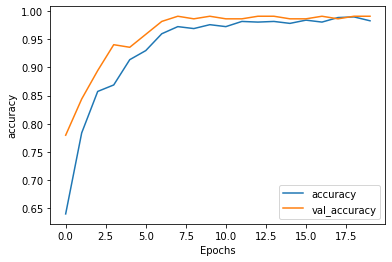

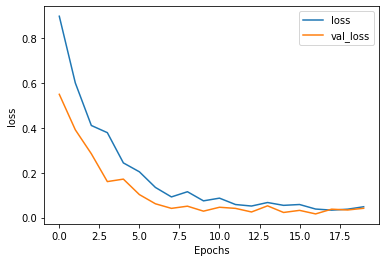

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
arg = np.argmax(a,axis=1)

In [ ]:
y_true = y_test.values

new_y_true = []

for y in y_true:
    new_y_true.append(y+1)

print(new_y_true)

[0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 1, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 1, 2, 2, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 1, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 0, 1, 2, 0, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 1, 2, 2, 1, 2, 1, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 1, 1, 2, 0, 2, 0, 0, 0, 0, 0, 1, 2, 1, 2, 0, 2, 2, 0, 1, 2, 2, 0, 2, 2, 0, 1, 2, 2, 0, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 0, 1, 2, 2, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 1, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 1, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 1, 2, 0, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 1, 0, 2, 2, 2, 0, 1, 2, 2, 2, 0, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 1, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 

In [ ]:
len(y_true)

467

In [ ]:
print(classification_report(new_y_true, arg))

              precision    recall  f1-score   support

           0       0.35      0.37      0.36       140
           1       0.17      0.10      0.12        51
           2       0.62      0.64      0.63       276

    accuracy                           0.50       467
   macro avg       0.38      0.37      0.37       467
weighted avg       0.49      0.50      0.49       467



In [ ]:


              precision    recall  f1-score   support

           0       0.32      0.34      0.33       140
           1       0.21      0.14      0.17        51
           2       0.62      0.64      0.63       276

    accuracy                           0.50       467
   macro avg       0.39      0.37      0.38       467
weighted avg       0.49      0.50      0.49       467
0.000004

IndentationError: ignored

test w TFBertForSequenceClassification tmr